In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams["axes.unicode_minus"] = False  ## 显示负号

In [3]:
# 高清
%config InlineBackend.figure_format ='retina'

In [1132]:
## 分类 五色
class_colors = ['E0D3BF','A35568','D97E96','6B6575','606968']
class_colors = ['#'+c for c in class_colors]
class_colors

['#E0D3BF', '#A35568', '#D97E96', '#6B6575', '#606968']

# 获取数据

In [4]:
rawdata = pd.read_excel('./华为-未来家庭.xlsx')

In [5]:
rawdata.columns[0:12]

Index(['序号', '提交答卷时间', '所用时间', '来源', '来源详情', '来自IP',
       '1. 您的性别（请在以下2个选项中选择一个作为您的回答）：', '2. 您的年龄（请在以下4个选项中选择一个作为您的回答）：',
       '3. 您的学历（请在以下3个选项中选择一个作为您的回答）：', '4. 职称类型（请在以下4个选项中选择一个作为您的回答）：',
       '5. 您目前从事的职业：', '6. 请您选择您现在所在省份城市：'],
      dtype='object')

In [6]:
rawdata_ = rawdata.rename(columns={'1. 您的性别（请在以下2个选项中选择一个作为您的回答）：':'性别','2. 您的年龄（请在以下4个选项中选择一个作为您的回答）：':'年龄',
                       '3. 您的学历（请在以下3个选项中选择一个作为您的回答）：':'学历','4. 职称类型（请在以下4个选项中选择一个作为您的回答）：':'职称类型',
                        '5. 您目前从事的职业：':'职业','6. 请您选择您现在所在省份城市：':'省份-市'
                       })

# 预处理

## 去掉填写问卷时间过长或过短的

- 原始标准差比较大，极差也很大，极端值多
- 因此我们选取 120s-1800s（不包括）的用户，其余作为无效数据删除
- 最后剩下 631 个数据


In [7]:
data1 = rawdata_.query('所用时间>120 & 所用时间<1800')

In [8]:
print(data1.shape)

(631, 66)


In [9]:
data1[['序号','所用时间']].describe()

,序号,所用时间
count,631.000000,631.000000
mean,361.988906,406.180666
std,207.776226,261.717148
min,1.000000,121.000000
25%,186.000000,229.000000
50%,364.000000,341.000000
75%,541.500000,495.000000
max,720.000000,1780.000000


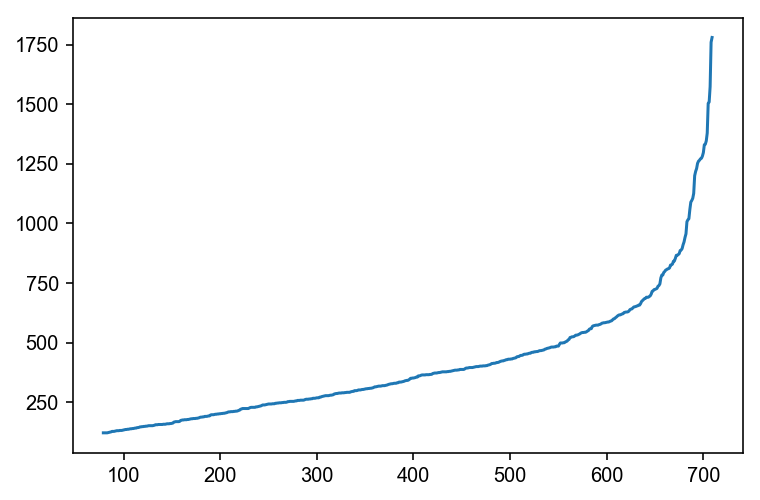

In [10]:
data1['所用时间'].plot()

## 去掉年龄25以下，本科以下的

In [11]:
data1 = data1.query('年龄!=1 | 学历!=3 | (年龄 == 1 & 学历 != 3) | (年龄 !=1 & 学历 == 3)')

In [12]:
data1.shape

(615, 66)

## 获得省-市

- 根据城市划分，发现只有11个省份在10人以上，因此选取这11个城市留存
- 分别是：
    - '山东', '浙江', '上海', '北京', '广东', '辽宁', '陕西', '江苏', '湖北', '河南', '四川'
- 11个城市包括的被试数量：580

In [13]:
province_city = data1['省份-市'].str.split('-',expand=True)

In [14]:
data1['省份'] = province_city[0]
data1['市'] = province_city[1]

In [15]:
data1['省份'].value_counts()

山东     101
浙江      90
上海      89
北京      57
广东      56
辽宁      42
陕西      40
江苏      28
湖北      26
河南      22
四川      14
河北       8
广西       7
内蒙古      6
山西       5
黑龙江      5
湖南       4
甘肃       4
吉林       3
新疆       2
贵州       1
重庆       1
天津       1
安徽       1
海外       1
宁夏       1
Name: 省份, dtype: int64

In [16]:
# 前11省： 山东-四川（19）
province_11 = data1['省份'].value_counts().index[0:11]

In [17]:
for city,d in data1.groupby('省份'):
    print(city,len(d))

上海 89
内蒙古 6
北京 57
吉林 3
四川 14
天津 1
宁夏 1
安徽 1
山东 101
山西 5
广东 56
广西 7
新疆 2
江苏 28
河北 8
河南 22
浙江 90
海外 1
湖北 26
湖南 4
甘肃 4
贵州 1
辽宁 42
重庆 1
陕西 40
黑龙江 5


In [18]:
province_11

Index(['山东', '浙江', '上海', '北京', '广东', '辽宁', '陕西', '江苏', '湖北', '河南', '四川'], dtype='object')

In [19]:
province_genders_man = []
province_genders_woman = []
for province in province_11:
    data_temp = data1[data1['省份']==province]
    gender_class = data_temp['性别'].value_counts()
    
    province_genders_man.append(gender_class[1])
    province_genders_woman.append(gender_class[2])

    

In [20]:
print(len(data1[data1['省份'].isin(list(province_11))]));

565


# 个人信息分析

## 城市-性别分析

- 大部分城市男女差异不大
- 但是湖北的男-85.2% ,比女生多很多，可以考虑删掉？

In [756]:
# 不同省份对应人数
province_population = {}
for province,data_groupby_province in data1.groupby('省份'):
    province_population[province] = len(data_groupby_province)
# province_population

In [21]:
province_genders_man_rate = []
province_genders_woman_rate = []
def get_gender_rate():
    for i in range(len(province_genders_man)):
        fm = province_genders_man[i]+province_genders_woman[i]
        man_rate = province_genders_man[i]/fm
        province_genders_man_rate.append(man_rate)
        woman_rate = province_genders_woman[i]/fm
        province_genders_woman_rate.append(woman_rate)
get_gender_rate()

In [22]:
data_gender1 = pd.DataFrame({'province':list(province_11),'man_number_rate':province_genders_man_rate})

In [23]:
data_gender2 = pd.DataFrame({'province':list(province_11),'woman_number_rate':province_genders_woman_rate})

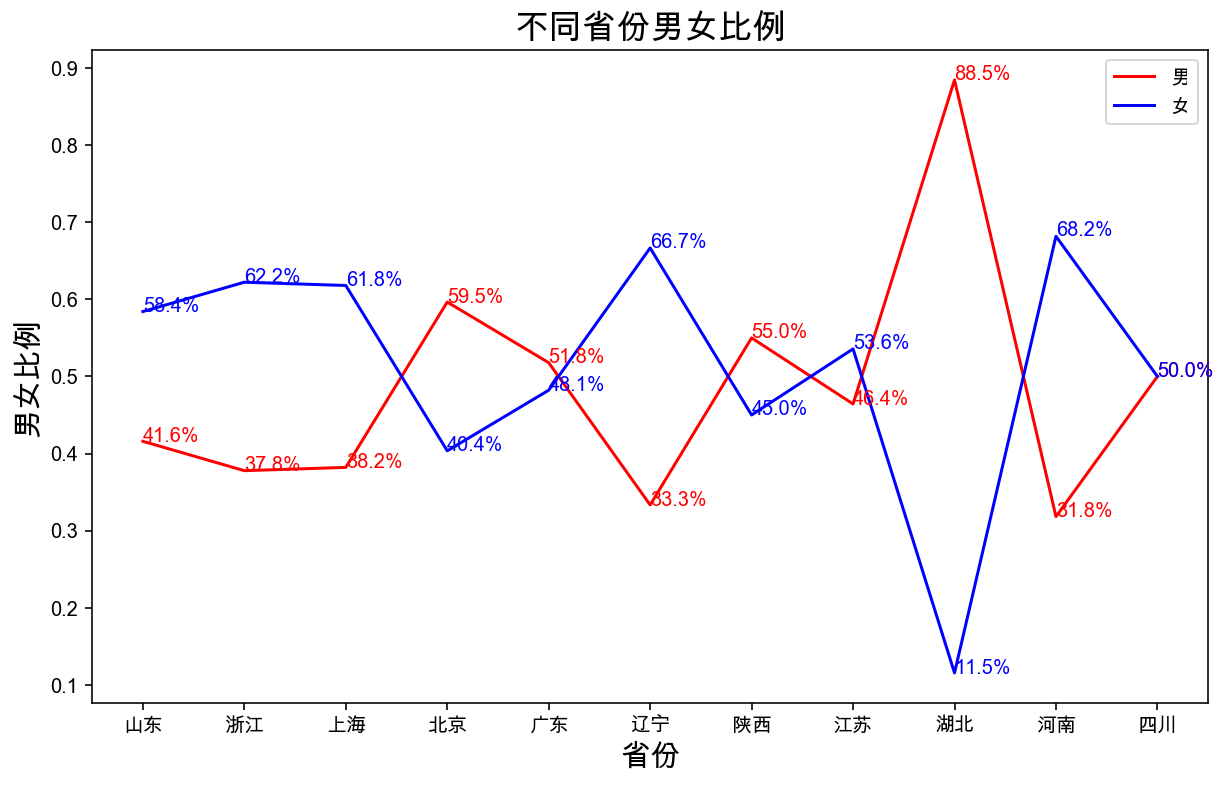

In [24]:
plt.figure(figsize=(10,6))
plt.plot(province_11,province_genders_man_rate,label='男',color='r')
plt.plot(province_11,province_genders_woman_rate,label='女',color='b')
for index in range(len(province_genders_man_rate)):
    man_rate = round(province_genders_man_rate[index],3)
    man_rate_str = str(100*man_rate)[0:4]+'%'
    woman_rate = round(province_genders_woman_rate[index],3)
    woman_rate_str = str(100*woman_rate)[0:4]+'%'
#     print(man_rate,man_rate_str)
    plt.text(index,man_rate,man_rate_str,color='r')
    plt.text(index,woman_rate,woman_rate_str,color='b')
plt.xlabel('省份',fontsize=15,)
plt.ylabel('男女比例',fontsize=15)
plt.legend()
plt.title('不同省份男女比例',fontsize=17)
# plt.legend(handles=[p1,p2],labels=['男','女'])
plt.savefig('./pic/city-gender.png',dpi=400)
plt.show()

In [190]:
gender_all

2    341
1    274
Name: 性别, dtype: int64

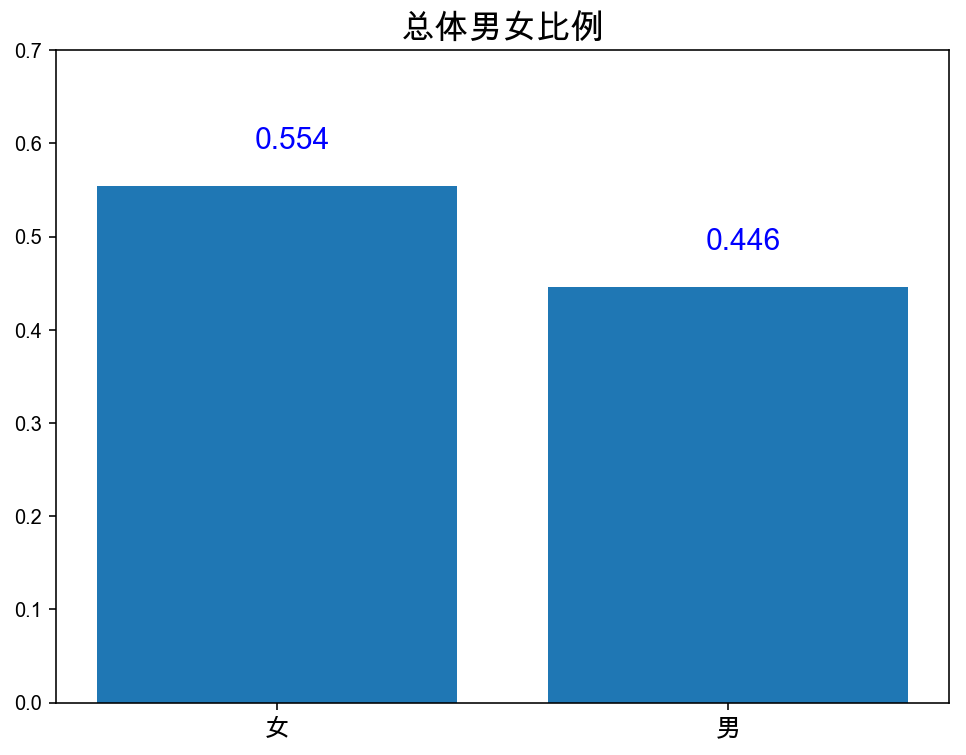

In [25]:
## 所有省份 年龄
plt.figure(figsize=(8,6))
gender_all = data1['性别'].value_counts()
sum_all = gender_all.sum()
gender_all_rate = [round(n/sum_all,3) for n in gender_all]
plt.bar(['女','男'],gender_all_rate)
plt.xticks([0,1],['女','男'],fontsize=13)
plt.ylim((0,0.7))
for i in range(2):
    plt.text(i-0.05,gender_all_rate[i]+0.04,str(gender_all_rate[i]),color='b',fontsize=15)
plt.title('总体男女比例',fontsize=17)
plt.savefig('./pic/gender_all.png',ppi=400)
plt.show()

## 城市-年龄

In [26]:
data1['年龄'].value_counts()
'''
1 - 25岁及以下
2 - 25～45岁
3 - 45～65岁
'''

'\n1 - 25岁及以下\n2 - 25～45岁\n3 - 45～65岁\n'

In [202]:
data3['年龄'].value_counts()

2    379
1    135
3     51
Name: 年龄, dtype: int64

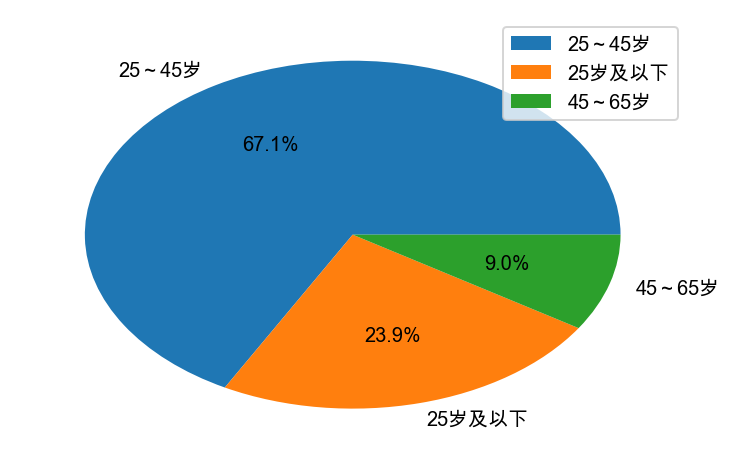

In [209]:
## 整体男女比例
all_num = sum(data3['年龄'].value_counts())
labels_ = ['25～45岁','25岁及以下','45～65岁']
plt.pie(x=data3['年龄'].value_counts(),labels = labels_ ,autopct='%1.1f%%',shadow=False)
plt.legend()
plt.savefig('./pic/age_rate_pie.png',ppi=600)
plt.show()

In [27]:
# 忽略 warning
import warnings
warnings.filterwarnings("ignore")

In [28]:
province_age1 = []
province_age2 = []
province_age3 = []
for province in province_11:
    data_province = data1[data1['省份']==province]
    dt1 = data_province[data1['年龄']==1]
    dt2 = data_province[data1['年龄']==2]
    dt3 = data_province[data1['年龄']==3]
    all_num = len(data_province)
    num2 = len(dt2)
    province_age2.append(num2)
    num1 = len(dt1)
    province_age1.append(num1)
    num3 = len(dt3)
    province_age3.append(num3)
province_age = [province_age1,province_age2,province_age3]
province_age 

[[16, 23, 30, 4, 4, 15, 7, 15, 8, 3, 10],
 [68, 63, 57, 50, 45, 23, 22, 11, 17, 19, 4],
 [17, 4, 2, 3, 7, 4, 11, 2, 1, 0, 0]]

In [29]:
# 比例
province_age_rate_1 = []
province_age_rate_2 = []
province_age_rate_3 = []
province_age_rate = [province_age_rate_1,province_age_rate_2,province_age_rate_3]
def get_province_age_rate():
    for num in range(len(province_11)):
        total = 0
        for ls in province_age:
            total += ls[num]
        for i,ls in enumerate(province_age):
            rate = round(ls[num]/total,3)
            province_age_rate[i].append(rate)
get_province_age_rate()         

In [30]:
province_age_rate

[[0.158, 0.256, 0.337, 0.07, 0.071, 0.357, 0.175, 0.536, 0.308, 0.136, 0.714],
 [0.673, 0.7, 0.64, 0.877, 0.804, 0.548, 0.55, 0.393, 0.654, 0.864, 0.286],
 [0.168, 0.044, 0.022, 0.053, 0.125, 0.095, 0.275, 0.071, 0.038, 0.0, 0.0]]

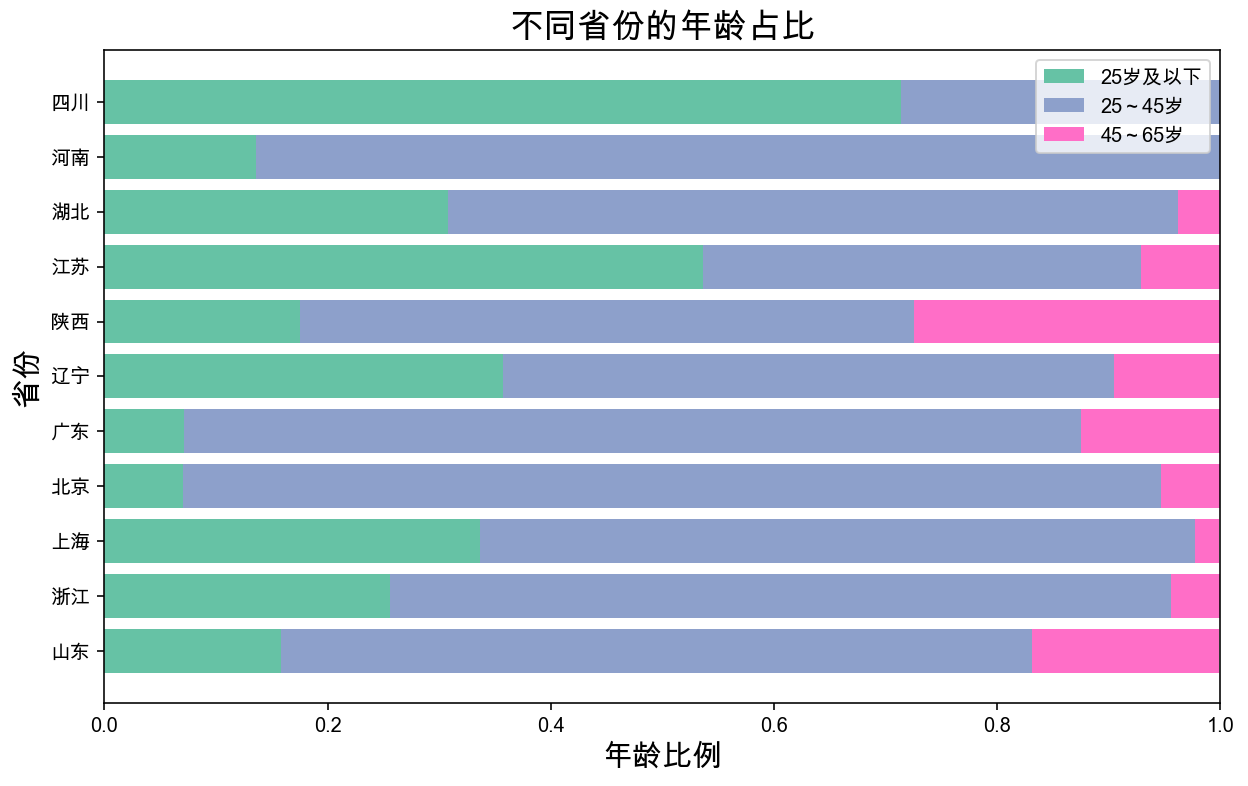

In [31]:
plt.figure(figsize=(10,6))
plt.barh(province_11, province_age_rate[0], align="center", color="#66c2a5", tick_label=province_11, label="25岁及以下")
plt.barh(province_11, province_age_rate[1], align="center", left=province_age_rate[0], color="#8da0cb", label="25～45岁")
plt.barh(province_11, province_age_rate[2], align="center", left=[province_age_rate[0][i]+province_age_rate[1][i] for i in range(len(province_11))], color="#FF6EC7", label="45～65岁")

plt.xlabel("年龄比例",fontsize=15)
plt.ylabel("省份",fontsize=15)

plt.legend()
plt.title('不同省份的年龄占比',fontsize=17)
plt.savefig('./pic/city-age.png',dpi=400)
plt.show()

## 职业分布

In [32]:
data_2 = data1[data1['省份'].isin(list(province_11))] ## 根据 城市和用时 去除用户后

In [33]:
job_data = data_2['职业'].value_counts()

In [34]:
job_data1 = job_data.rename({
    1:'全日制学生',
    2:'生产人员',
    3:'销售人员',
    4:'市场/公关人员',
    5:'客服人员',
    6:'行政/后勤人员',
    7:'人力资源',
    8:'财务/审计人员',
    9:'文职/办事人员',
    10:'技术/研发人员',
    11:'管理人员',
    12:'教师',
    13:'顾问/咨询',
    14:'专业人士(如会计师、律师等)',
    15:'其他'
});

In [210]:
sum(list(job_data1))

565

In [211]:
job_data1

教师                153
全日制学生             119
技术/研发人员            62
其他                 50
管理人员               31
销售人员               30
行政/后勤人员            28
专业人士(如会计师、律师等)     22
文职/办事人员            20
财务/审计人员            12
人力资源               11
市场/公关人员             9
生产人员                9
顾问/咨询               5
客服人员                4
Name: 职业, dtype: int64

In [214]:
job_data1_rate = [round(n/565,3) for n in job_data1]
job_data1_rate[-1] = 0
job_data1_rate[-1] = round(1-sum(job_data1_rate),3)
job_data1_rate

[0.271,
 0.211,
 0.11,
 0.088,
 0.055,
 0.053,
 0.05,
 0.039,
 0.035,
 0.021,
 0.019,
 0.016,
 0.016,
 0.009,
 0.007]

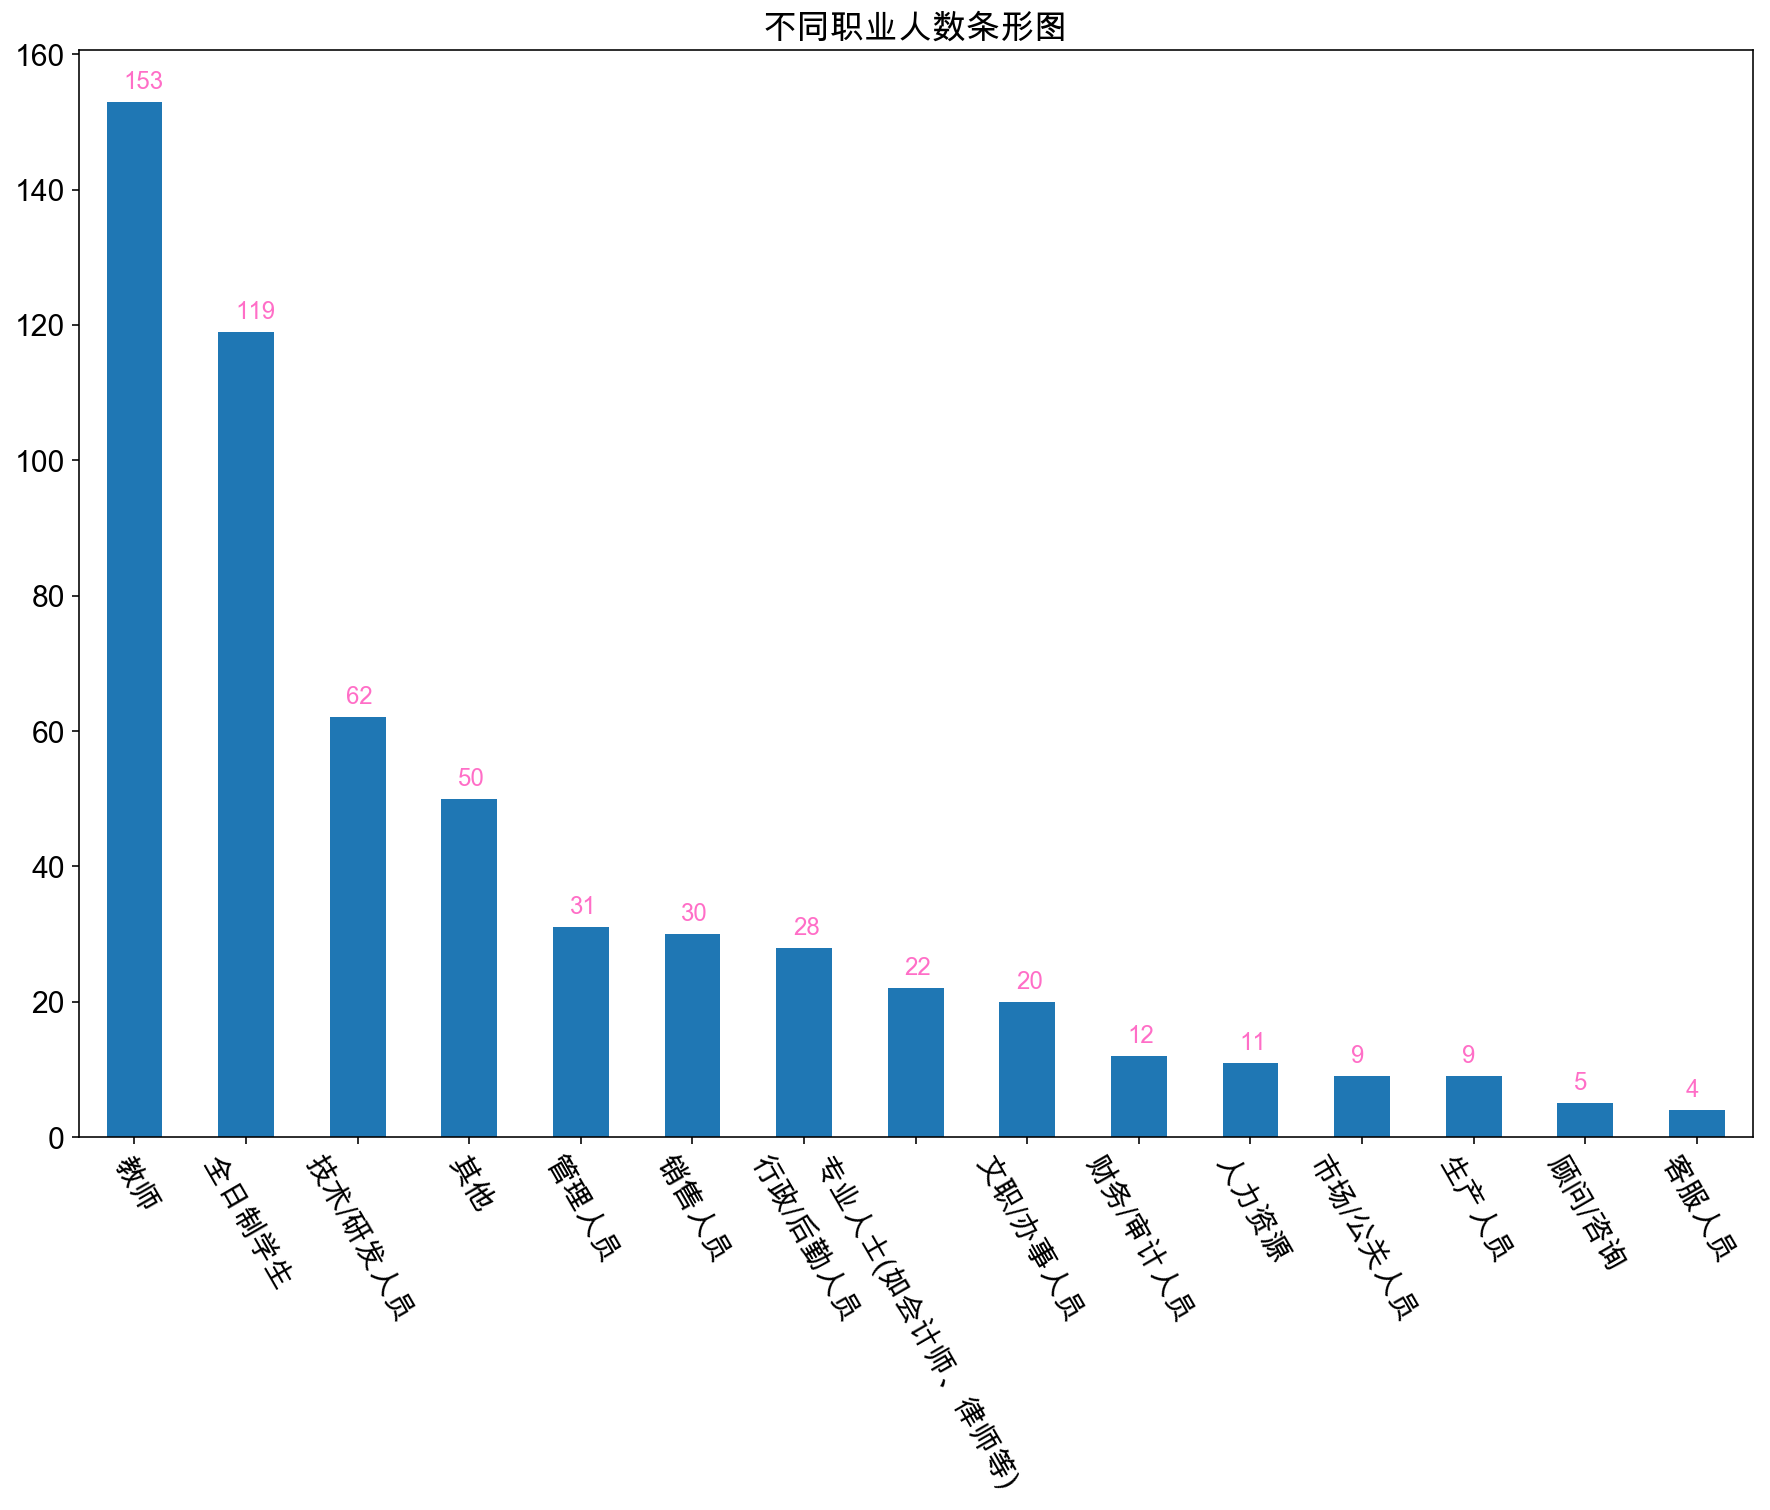

In [36]:
plt.figure(figsize=(15,10))
pic = job_data1.plot(kind='bar',fontsize=15,rot=-60)
for i in range(len(job_data1.index)):
    number = list(job_data1)[i]
    str_num = str(number)
    number = list(job_data1)[i]+2
    plt.text(i-0.1,number,str_num,color='#FF6EC7',fontsize=12)
plt.title('不同职业人数条形图',fontsize=17)
plt.savefig('./pic/job.png',dpi=400)
plt.show()

## 学历分布


In [219]:
data_2['学历'].value_counts()
'''
1-研究生
2-本科
3-本科以下
'''
edu_rate = [round(edu/sum(data_2['学历'].value_counts()),3) for edu in data_2['学历'].value_counts()]

In [220]:
edu_rate

[0.533, 0.368, 0.099]

# 问题分析(主题角度）

## 更改 index

In [37]:
index_1 = [7,8,9,10,11,12]
index_2 = [1,2]
index_3 = [
    range(1,6),
    range(1,8),
    range(1,10),
    range(1,6),
    range(1,7),
    range(1,17),
]

index_all = []
for k,i1 in enumerate(index_1):
    for i2 in index_2:
        if i2 == 1:
            i3_s = index_3[k]
            for i3 in i3_s:
                no = str(i1)+'-'+str(i2)+'-'+str(i3)
                index_all.append(no)
        elif i2 == 2:
            no = str(i1)+'-'+str(i2) +'-1'
            index_all.append(no)            

In [38]:
new_cols = ['序号', '提交答卷时间', '所用时间', '来源', '来源详情', '来自IP', '性别', '年龄', '学历', '职称类型',
       '职业', '省份-市']+ index_all+['省份','市']

In [39]:
print(len(new_cols),len(data_2.columns))

68 68


In [40]:
data_2.columns = new_cols

## 智能家居热门主题

In [41]:
## 专门算积分
data3 = data_2

In [42]:
data3['省份'].replace('四川','sc')
data3['省份'].value_counts()

山东    101
浙江     90
上海     89
北京     57
广东     56
辽宁     42
陕西     40
江苏     28
湖北     26
河南     22
四川     14
Name: 省份, dtype: int64

In [1031]:
data3.to_excel('./data_1.xlsx')

In [43]:
for index in index_all:
    data3[index] = data3[index].replace(1,-2)
    data3[index] = data3[index].replace(2,-1)
    data3[index] = data3[index].replace(3,1)
    data3[index] = data3[index].replace(4,2)


### 主题-all

In [44]:
sum_map1 = {}
for i in range(1,6):
    sum_map1[f'7-1-{i}'] = data3[f'7-1-{i}'].sum()
sum_map1 = sorted(sum_map1.items(),key = lambda x:x[1],reverse = True)
sum_map1 = dict(sum_map1)

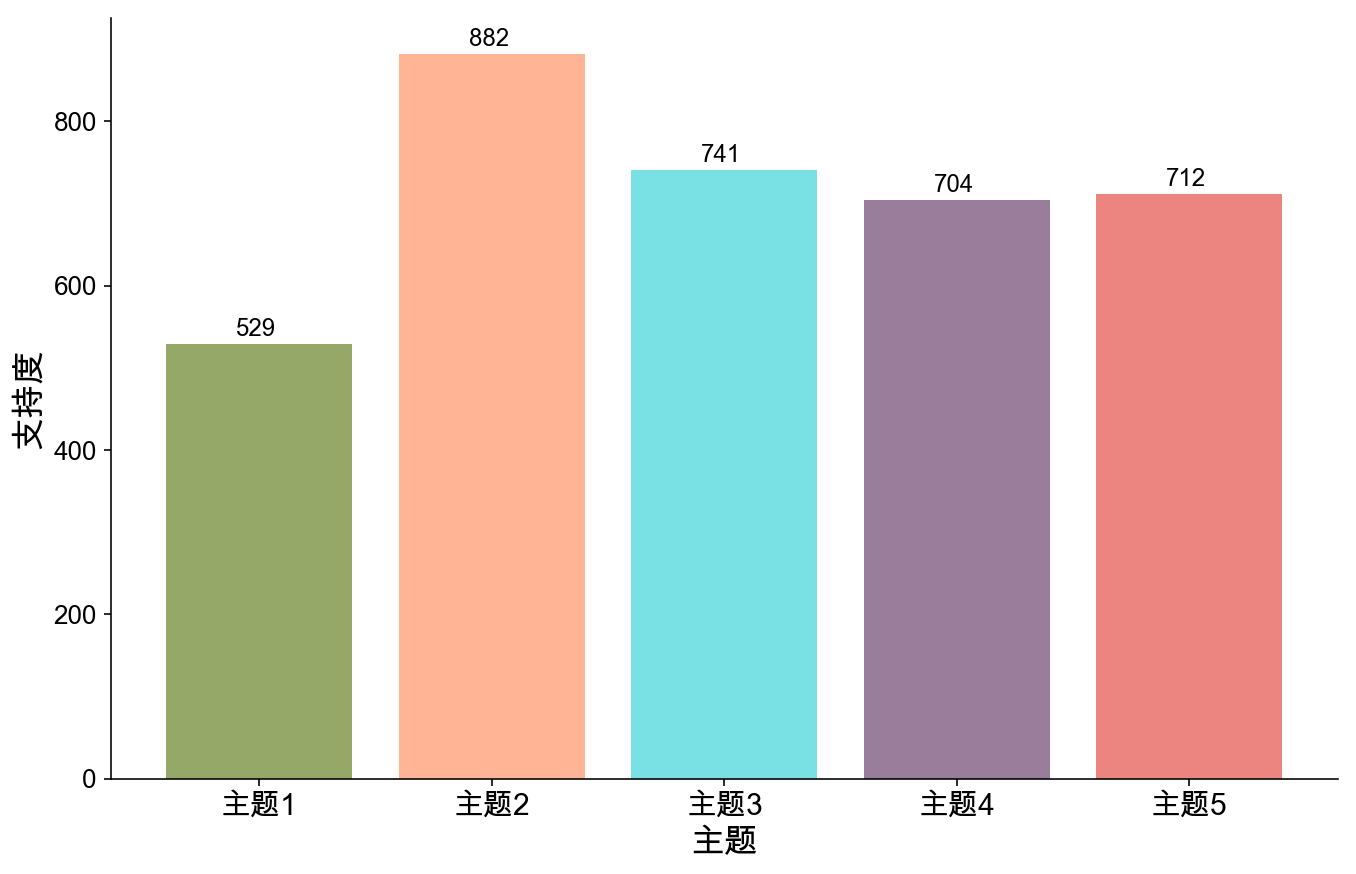

In [1053]:

suject_hot = dict()
suject_hot['主题1'] = sum_map1['7-1-1']
suject_hot['主题2'] = sum_map1['7-1-2']
suject_hot['主题3'] = sum_map1['7-1-3']
suject_hot['主题4'] = sum_map1['7-1-4']
suject_hot['主题5'] = sum_map1['7-1-5']

# colors = ['#66c2a5','#44cef6','#e9bb1d','#afdd22','#f00056']
colors = ['#7B9242','#FFA17B','#58D9DE','#805c82','#E86761']

fig, ax = plt.subplots(figsize=(11,7))
for i in range(5):
    plt.bar(list(suject_hot.keys())[i],list(suject_hot.values())[i],color = colors[i],alpha=0.8)
    plt.text(i-0.1,list(suject_hot.values())[i]+10,str(list(suject_hot.values())[i]),color='black',fontsize=12)
plt.xlabel('主题',fontsize = 17)
plt.ylabel('支持度',fontsize = 17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.title('五个主题的支持度',fontsize=17)
plt.savefig('./pic/subject_support.png',dpi=500)
plt.show()

In [1057]:
colors_rgb = {}
for ii,color in enumerate(colors):
    color_rgb = Hex_to_RGB(color)
    colors_rgb[f'主题{ii+1}'] = color_rgb
colors_rgb  

123,146,66
255,161,123
88,217,222
128,92,130
232,103,97


{'主题1': '123,146,66',
 '主题2': '255,161,123',
 '主题3': '88,217,222',
 '主题4': '128,92,130',
 '主题5': '232,103,97'}

### 主题-1

In [573]:
import seaborn as sns

In [574]:
sum_map2 = {}
for i in range(1,8):
    sum_map2[f'8-1-{i}'] = data3[f'8-1-{i}'].sum()
sum_map2 = sorted(sum_map2.items(),key = lambda x:x[1],reverse = True)
sum_map2 = dict(sum_map2)
sum_map2_pd = pd.Series(sum_map2)

In [575]:
def RGB_to_Hex(rgb):
    ## rgb -> 16
    RGB = rgb.split(',')  # 将RGB格式划分开来
    color = '#'
    for i in RGB:
        num = int(i)
        # 将R、G、B分别转化为16进制拼接转换并大写  hex() 函数用于将10进制整数转换成16进制，以字符串形式表示
        color += str(hex(num))[-2:].replace('x', '0').upper()
    print(color)
    return color

def Hex_to_RGB(hex):
    ## 16 -> rgb
    r = int(hex[1:3], 16)
    g = int(hex[3:5], 16)
    b = int(hex[5:7], 16)
    rgb = str(r) + ',' + str(g) + ',' + str(b)
    print(rgb)
    return rgb

In [576]:
Hex_to_RGB('#66c2a5')

102,194,165


'102,194,165'

In [577]:
bar_number1 = 7
gs = np.linspace(150,255,bar_number1)
gs = [int(g) for g in gs]
colors_rgb = [f'102,{g},165' for g in gs]
colors_hex = [RGB_to_Hex(rgb) for rgb in colors_rgb]

#6696A5
#66A7A5
#66B9A5
#66CAA5
#66DCA5
#66EDA5
#66FFA5


In [578]:
sum_map2_pd.describe()

count      7.000000
mean     736.857143
std      205.848997
min      291.000000
25%      736.500000
50%      834.000000
75%      852.000000
max      856.000000
dtype: float64

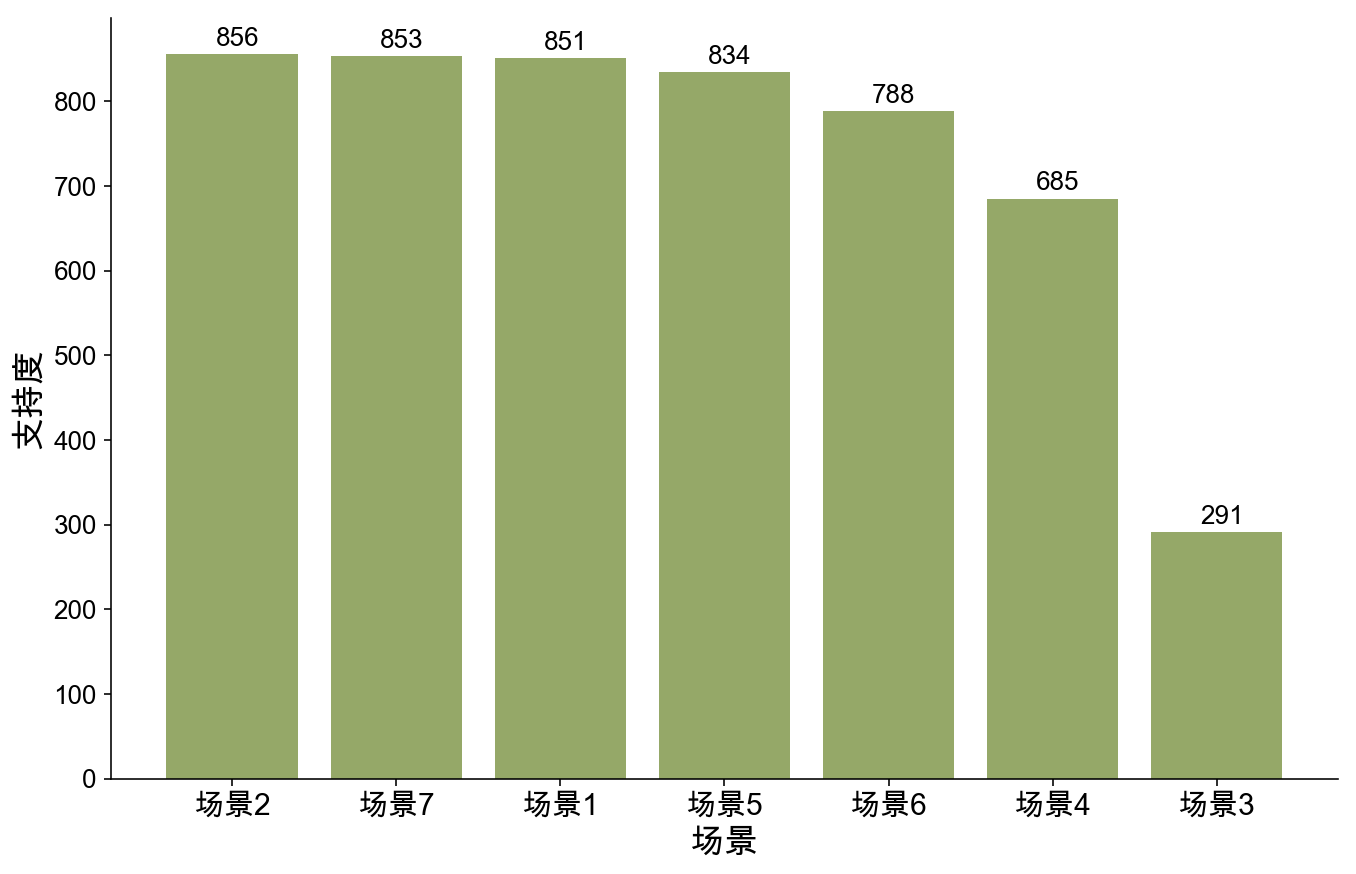

In [1126]:
bar_number1 = 7
fig, ax = plt.subplots(figsize=(11,7))
indexs = [f"场景{cj.split('-')[-1]}" for cj in sum_map2_pd.index]
for i in range(bar_number1):
    plt.bar(indexs[i],list(sum_map2_pd)[i],color='#7B9242',alpha=0.8)
    plt.text(i-0.1,list(sum_map2_pd)[i]+10,str(list(sum_map2_pd)[i]),fontsize=13)
# plt.title('主题1-不同场景的关注度',fontsize=17)
plt.xlabel('场景',fontsize = 17)
plt.ylabel('支持度',fontsize = 17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./pic/主题1-关注度.png',dpi=400)
plt.show()

### 主题-2

In [568]:
sum_map3 = {}
for i in range(1,10):
    sum_map3[f'9-1-{i}'] = data3[f'9-1-{i}'].sum()
sum_map3 = sorted(sum_map3.items(),key = lambda x:x[1],reverse = True)
sum_map3 = dict(sum_map3)
sum_map3_pd = pd.Series(sum_map3)

In [569]:
sum_map3_pd.describe()

count      9.000000
mean     771.555556
std      108.864722
min      594.000000
25%      726.000000
50%      776.000000
75%      855.000000
max      898.000000
dtype: float64

In [570]:
Hex_to_RGB('#44cef6')

68,206,246


'68,206,246'

In [571]:
bar_number2 = 9
gs = np.linspace(200,255,bar_number2)
gs = [int(g) for g in gs]
colors_rgb = [f'68,206,{g}' for g in gs]
colors_hex = [RGB_to_Hex(rgb) for rgb in colors_rgb]

#44CEC8
#44CECE
#44CED5
#44CEDC
#44CEE3
#44CEEA
#44CEF1
#44CEF8
#44CEFF


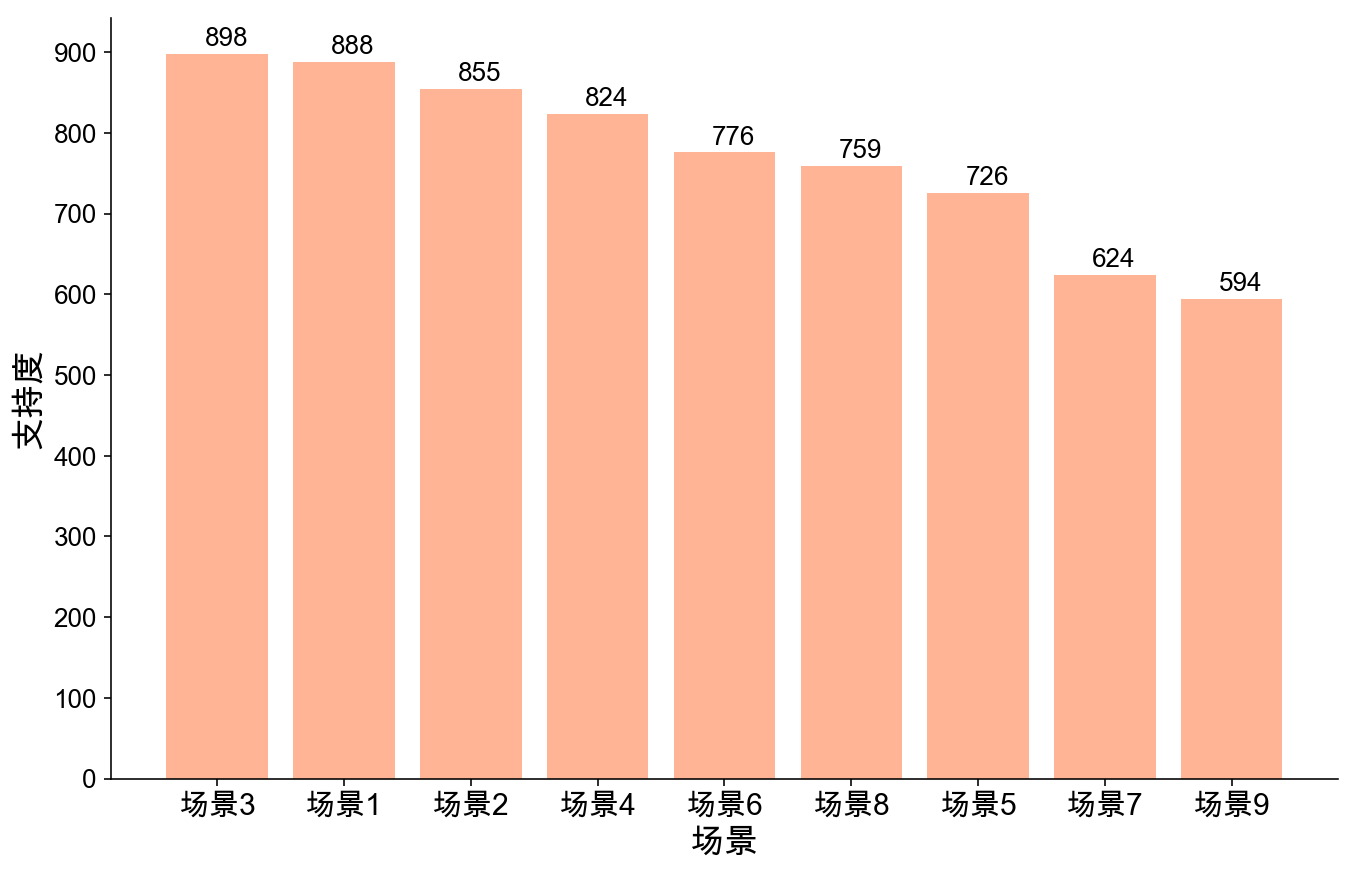

In [1127]:
bar_number2 = 9
fig, ax = plt.subplots(figsize=(11,7))
ax2=plt.gca()
#ax为两条坐标轴的实例
y_major_locator=MultipleLocator(100)
#把y轴的刻度间隔设置为10，并存在变量里
ax2.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为10的倍数
indexs = [f"场景{cj.split('-')[-1]}" for cj in sum_map3_pd.index]
for i in range(bar_number2):
    plt.bar(indexs[i],list(sum_map3_pd)[i],color='#FFA17B',alpha=0.8)
    plt.text(i-0.1,list(sum_map3_pd)[i]+10,str(list(sum_map3_pd)[i]),fontsize=13)
plt.xlabel('场景',fontsize = 17)
plt.ylabel('支持度',fontsize = 17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.title('主题2-不同场景的关注度',fontsize=17)
plt.savefig('./pic/主题2-关注度.png',dpi=400)
plt.show()

### 主题-3

In [562]:
sum_map4 = {}
for i in range(1,6):
    sum_map4[f'10-1-{i}'] = data3[f'10-1-{i}'].sum()
sum_map4 = sorted(sum_map4.items(),key = lambda x:x[1],reverse = True)
sum_map4= dict(sum_map4)
sum_map4_pd = pd.Series(sum_map4)

In [563]:
sum_map4_pd.describe()

count      5.00000
mean     713.40000
std       98.99899
min      538.00000
25%      736.00000
50%      756.00000
75%      764.00000
max      773.00000
dtype: float64

In [564]:
Hex_to_RGB('#e9bb1d')

233,187,29


'233,187,29'

In [565]:
bar_number3 = 5
gs = np.linspace(150,200,bar_number3)
gs = [int(g) for g in gs]
colors_rgb = [f'233,{g},29' for g in gs]
colors_hex = [RGB_to_Hex(rgb) for rgb in colors_rgb]

#E9961D
#E9A21D
#E9AF1D
#E9BB1D
#E9C81D


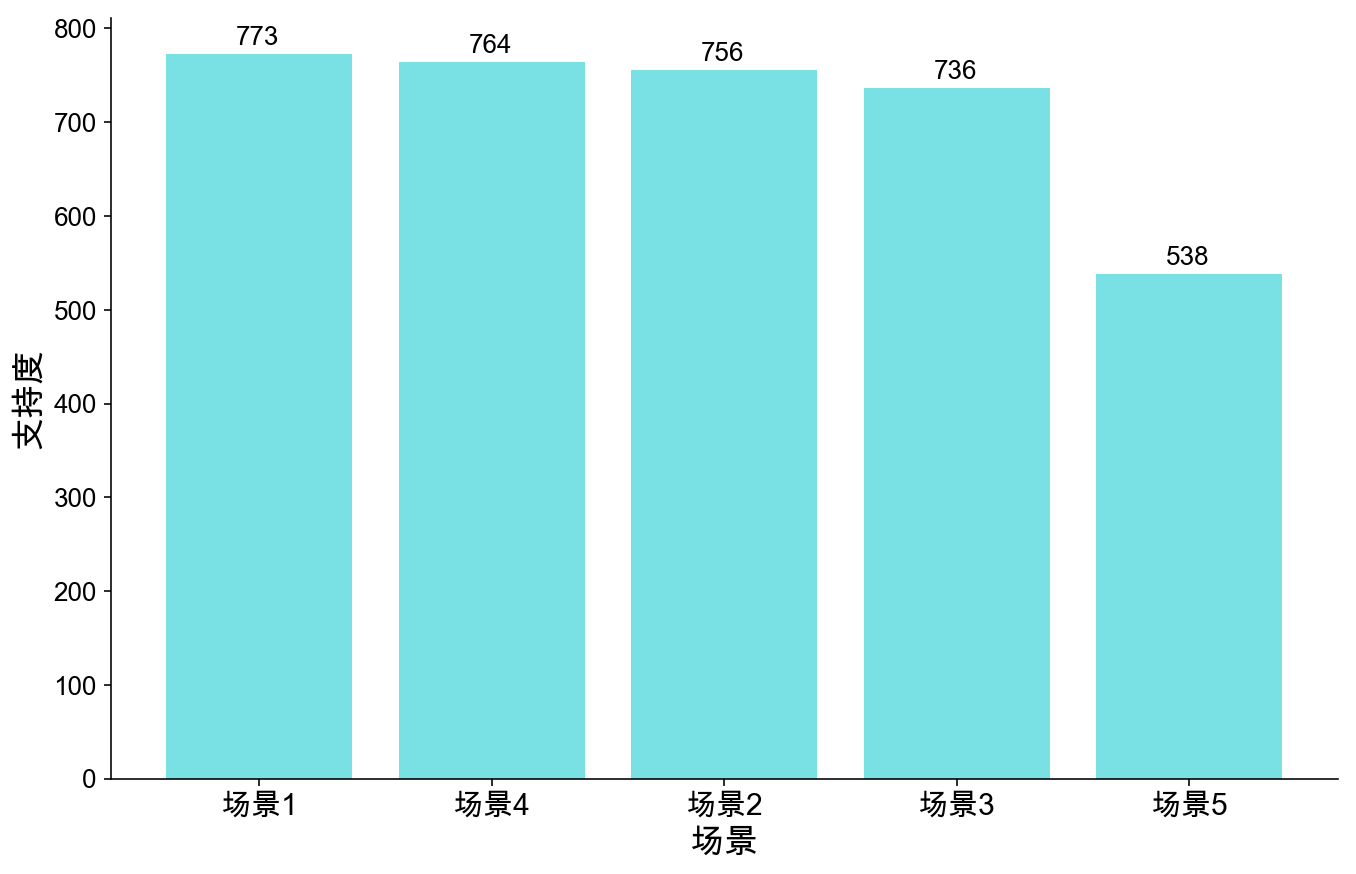

In [1128]:
bar_number3 = 5
fig, ax = plt.subplots(figsize=(11,7))
indexs = [f"场景{cj.split('-')[-1]}" for cj in sum_map4_pd.index]
for i in range(bar_number3):
    plt.bar(indexs[i],list(sum_map4_pd)[i],color='#58D9DE',alpha=0.8)
    plt.text(i-0.1,list(sum_map4_pd)[i]+10,str(list(sum_map4_pd)[i]),fontsize=13)
plt.xlabel('场景',fontsize = 17)
plt.ylabel('支持度',fontsize = 17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.title('主题3-不同场景的关注度',fontsize=17)
plt.savefig('./pic/主题3-关注度.png',dpi=400)
plt.show()

### 主题-4

In [557]:
sum_map5 = {}
for i in range(1,7):
    sum_map5[f'11-1-{i}'] = data3[f'11-1-{i}'].sum()
sum_map5 = sorted(sum_map5.items(),key = lambda x:x[1],reverse = True)
sum_map5 = dict(sum_map5)
sum_map5_pd = pd.Series(sum_map5)

In [558]:
sum_map5_pd.describe()

count      6.000000
mean     669.166667
std      130.180516
min      409.000000
25%      688.500000
50%      711.500000
75%      740.500000
max      752.000000
dtype: float64

In [559]:
Hex_to_RGB('#afdd22')

175,221,34


'175,221,34'

In [560]:
bar_number4 = 6
gs = np.linspace(200,250,bar_number4)
gs = [int(g) for g in gs]
colors_rgb = [f'175,{g},34' for g in gs]
colors_hex = [RGB_to_Hex(rgb) for rgb in colors_rgb]

#AFC822
#AFD222
#AFDC22
#AFE622
#AFF022
#AFFA22


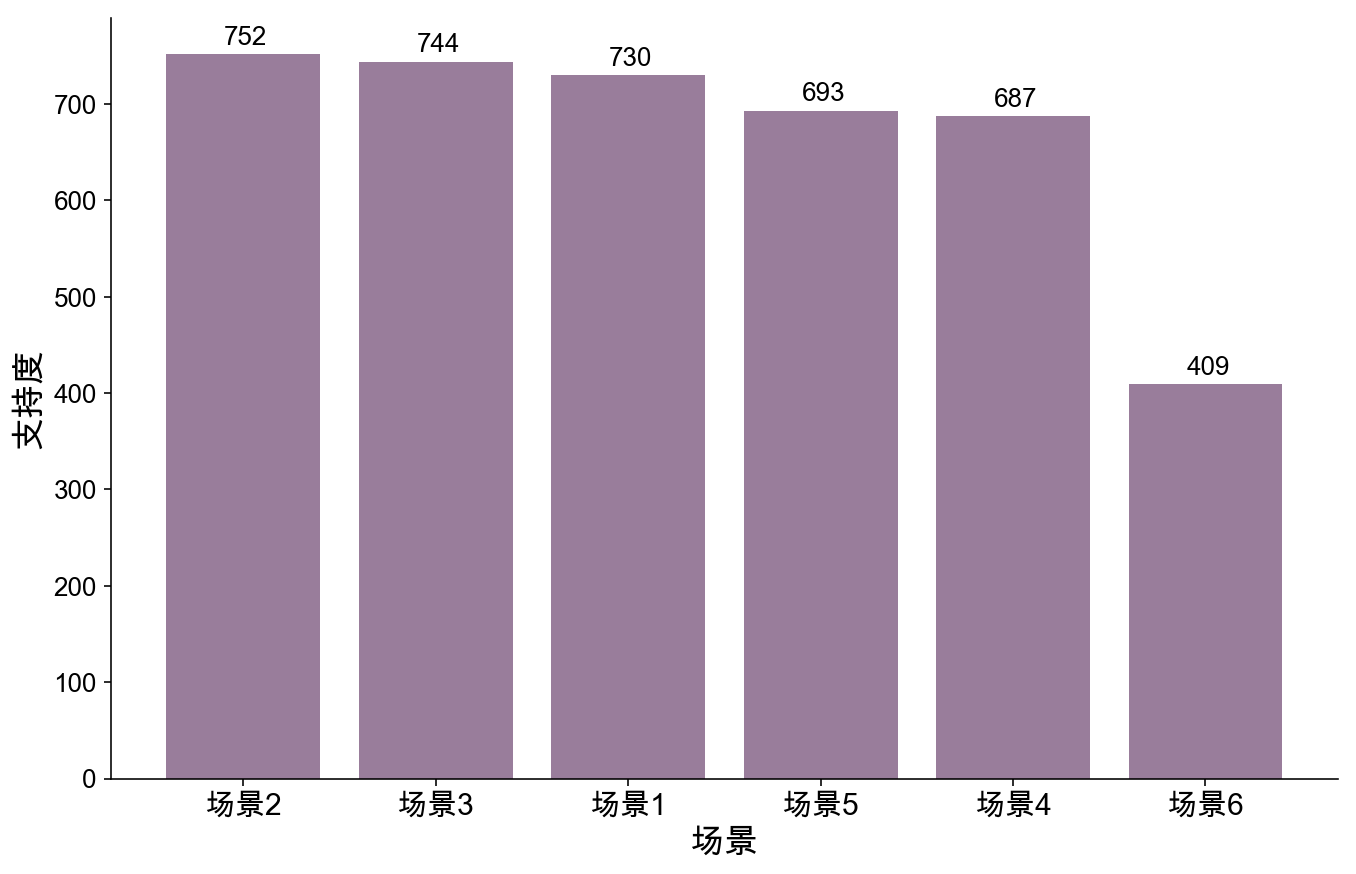

In [1130]:
bar_number4 = 6
fig, ax = plt.subplots(figsize=(11,7))
indexs = [f"场景{cj.split('-')[-1]}" for cj in sum_map5_pd.index]
for i in range(bar_number4):
    plt.bar(indexs[i],list(sum_map5_pd)[i],color = '#805c82',alpha=0.8)
    plt.text(i-0.1,list(sum_map5_pd)[i]+10,str(list(sum_map5_pd)[i]),fontsize=13)
plt.xlabel('场景',fontsize = 17)
plt.ylabel('支持度',fontsize = 17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.title('主题4-不同场景的关注度',fontsize=17)
plt.savefig('./pic/主题4-关注度.png',dpi=400)
plt.show()

### 主题-5

In [542]:
sum_map6 = {}
for i in range(1,17):
    sum_map6[f'12-1-{i}'] = data3[f'12-1-{i}'].sum()
sum_map6 = sorted(sum_map6.items(),key = lambda x:x[1],reverse = True)
sum_map6 = dict(sum_map6)
sum_map6_pd = pd.Series(sum_map6)

In [543]:
sum_map6_pd.describe()

count     16.000000
mean     709.562500
std       80.208868
min      528.000000
25%      678.250000
50%      699.000000
75%      754.000000
max      864.000000
dtype: float64

In [544]:
Hex_to_RGB('#f00056')

240,0,86


'240,0,86'

In [545]:
bar_number5 = 16
gs = np.linspace(150,250,bar_number5)
gs = [int(g) for g in gs]
colors_rgb = [f'{g},0,86' for g in gs]
colors_hex = [RGB_to_Hex(rgb) for rgb in colors_rgb]

#960056
#9C0056
#A30056
#AA0056
#B00056
#B70056
#BE0056
#C40056
#CB0056
#D20056
#D80056
#DF0056
#E60056
#EC0056
#F30056
#FA0056


In [546]:
from matplotlib.pyplot import MultipleLocator
#从pyplot导入MultipleLocator类，这个类用于设置刻度间隔


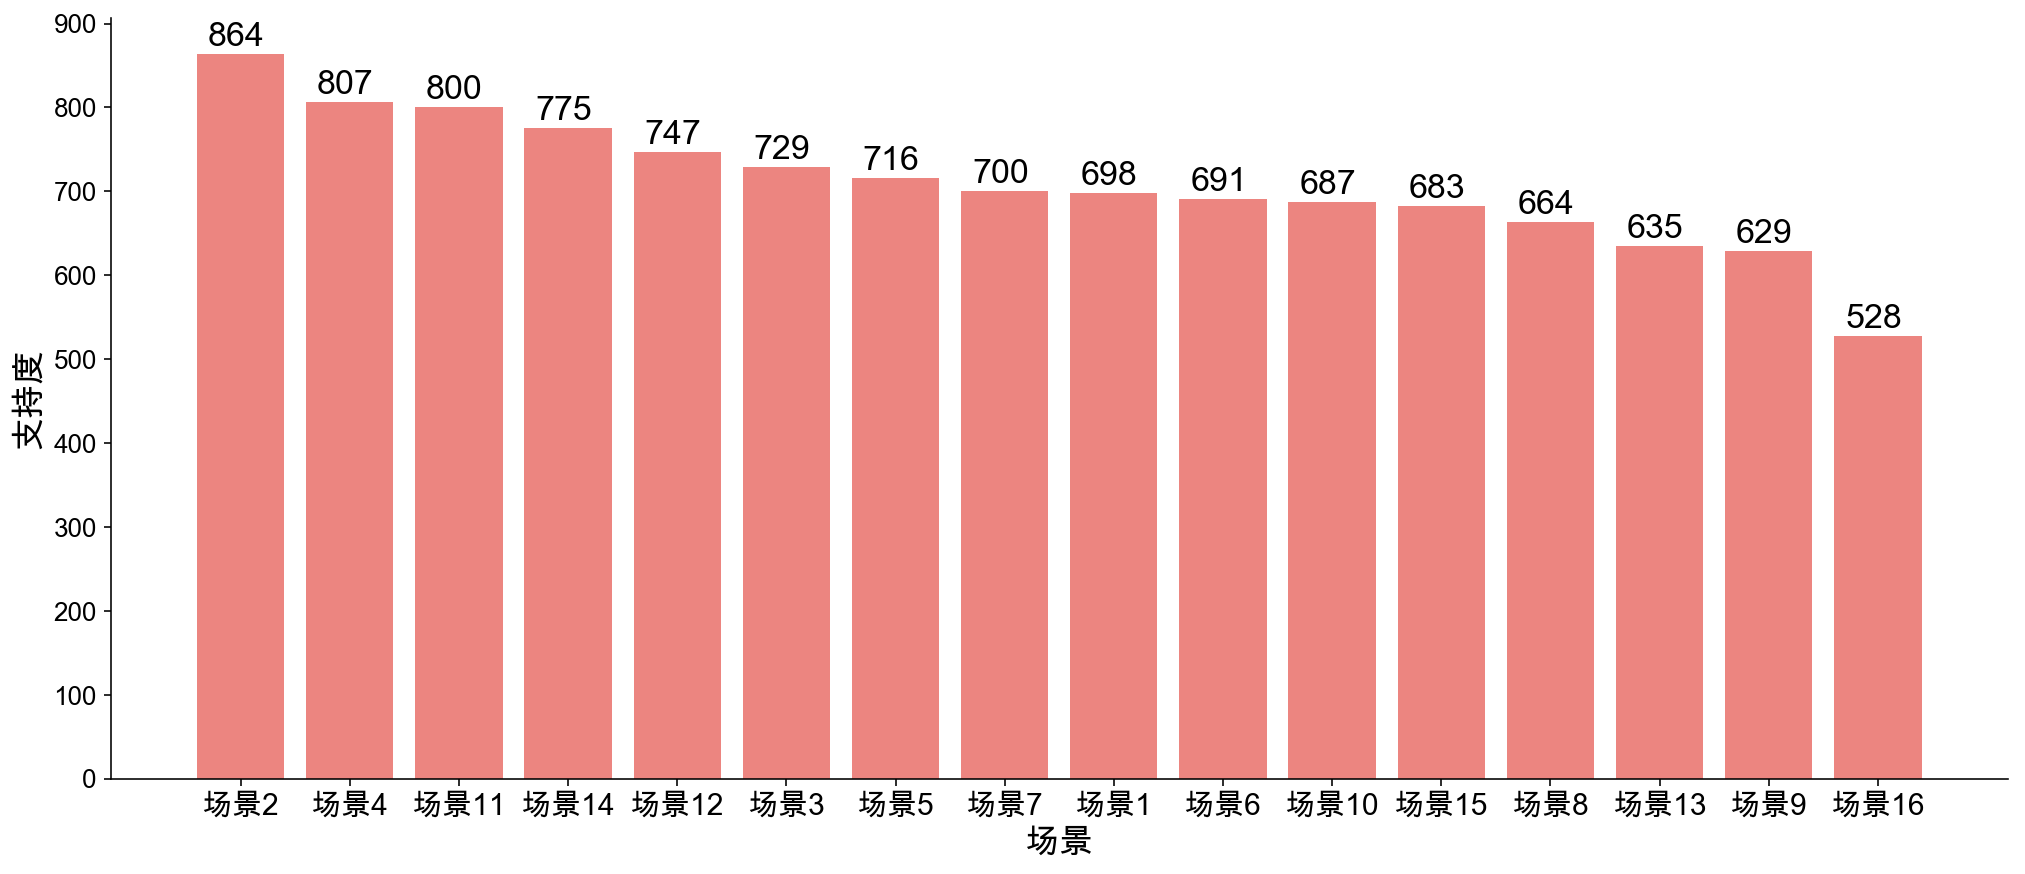

In [1131]:
bar_number5 = 16
fig, ax = plt.subplots(figsize=(17,7))
ax2=plt.gca()
#ax为两条坐标轴的实例
y_major_locator=MultipleLocator(100)
#把y轴的刻度间隔设置为10，并存在变量里
ax2.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为10的倍数
indexs = [f"场景{cj.split('-')[-1]}" for cj in sum_map6_pd.index]
for i in range(bar_number5):
    plt.bar(indexs[i],list(sum_map6_pd)[i],color='#E86761',alpha=0.8)
    plt.text(i-0.3,list(sum_map6_pd)[i]+10,str(list(sum_map6_pd)[i]),fontsize=17)
# plt.title('主题5-不同场景的关注度',fontsize=17)
plt.xlabel('场景',fontsize = 17)
plt.ylabel('支持度',fontsize = 17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./pic/主题5-关注度.png',dpi=400)
# plt.yscale(100)
plt.show()

## 方差分析

In [851]:
cols = ['7-1-1','7-1-2','7-1-3','7-1-4','7-1-5']

In [853]:
data4 = data3[cols].stack()
data4.index.names = ['id','tm']

In [854]:
index2 = [ind[1] for ind in data4.index]
data4.index = index2

In [855]:
index2_data = {}
for i in range(len(index2)):
    index2_data[i] = {'question':list(index2)[i],'score':data4[i]}
data5 = pd.DataFrame.from_dict(index2_data,orient='index')

In [856]:
data5

,question,score
0,7-1-1,1
1,7-1-2,1
2,7-1-3,1
3,7-1-4,1
4,7-1-5,1
...,...,...
2820,7-1-1,1
2821,7-1-2,2
2822,7-1-3,1
2823,7-1-4,1


In [398]:
'''实现单因素方差分析'''
# 导入相关包
import math
import scipy
from scipy import stats 
 
# 自定义函数
 
def SST(Y):
    sst = sum(np.power(Y - np.mean(Y), 2))
    return sst
 
def SSA(data, x_name, y_name):
    total_avg = np.mean(data[y_name])
    df = data.groupby([x_name]).agg(['mean', 'count'])
    df = df[y_name]
    ssa = sum(df["count"]*(np.power(df["mean"] - total_avg, 2)))
    return ssa
 
def SSE(data, x_name, y_name):
    df = data.groupby([x_name]).agg(['mean'])
    
    df = df[y_name]
    #dict_ = dict(df["mean"]) 用dict函数报错
    dict_=df["mean"].to_dict()
    data_ = data[[x_name, y_name]]
    data_["add_mean"] = data_[x_name].map(lambda x: dict_[x])
    sse = sum(np.power(data_[y_name] - data_["add_mean"], 2))
    return sse
 
def one_way_anova(data, x_name, y_name, alpha=0.05):
    '''
    单因素方差分析
    '''
    n = len(data)                     # 总观测值数
    k = len(data[x_name].unique())    # 变量水平个数
    
    sst = SST(data[y_name])           # 总平方和
    ssa = SSA(data, x_name, y_name)   # 组间平方和
    sse = SSE(data, x_name, y_name)   # 组内平方和
    
    msa = ssa / (k-1)  # 组间均方 或 组间方差
    mse = sse / (n-k)  # 组内均方 或 组内方差
    F = msa / mse      # 检验统计量F
    pf = scipy.stats.f.sf(F, k-1, n-k)  
    Fa = scipy.stats.f.isf(alpha, dfn=k-1, dfd=n-k)   # F临界值
    
    r_square = ssa / sst  # 自变量与因变量的关系强度表示
    
    table = pd.DataFrame({'差异源':['组间', '组内', '总和'],
                          '平方和SS':[ssa, sse, sst],
                          '自由度df':[k-1, n-k, n-1],
                          '均方MS':[msa, mse, '_'],
                          'F值':[F, '_', '_'],
                          'P值':[pf, '_', '_'],
                          'F临界值':[Fa, '_', '_'],
                          'R^2':[r_square, '_', '_']})
    
    return table


In [399]:
one_way_anova(data5, 'question', 'score', alpha=0.05)

,差异源,平方和SS,自由度df,均方MS,F值,P值,F临界值,R^2
0,组间,112.002124,4,28.0005,39.3316,4.30433e-32,2.37508,0.0528415
1,组内,2007.582301,2820,0.711909,_,_,_,_
2,总和,2119.584425,2824,_,_,_,_,_


## 年龄-主题支持度分析

In [864]:
data3.head()

,序号,提交答卷时间,所用时间,来源,来源详情,来自IP,性别,年龄,学历,职称类型,...,12-1-10,12-1-11,12-1-12,12-1-13,12-1-14,12-1-15,12-1-16,12-2-1,省份,市
0,98,2020/8/18 13:38:11,121,微信,NaN,117.136.5.141(辽宁-沈阳),1,1,2,4,...,1,1,1,1,1,1,1,(空),辽宁,沈阳
1,515,2020/8/20 10:00:13,121,链接,直接访问,42.196.155.55(上海-上海),2,2,1,4,...,2,2,2,2,1,1,1,(空),上海,徐汇区
2,665,2020/8/20 21:21:38,121,微信,NaN,183.193.63.73(上海-上海),2,2,2,2,...,2,2,1,1,1,1,1,(空),上海,普陀区
3,686,2020/8/21 9:54:55,121,手机提交,直接访问,117.136.78.118(山东-青岛),1,2,1,2,...,1,1,1,1,1,1,1,(空),山东,济南
4,549,2020/8/20 10:58:58,122,微信,NaN,223.104.212.99(上海-上海),2,2,2,2,...,1,1,1,1,1,2,1,(空),上海,黄浦区


In [863]:
data3.index = range(data3.shape[0])

In [871]:
count =0
hang = 0
data_age_subject_support = pd.DataFrame(data=None,columns=['id','年龄','主题','支持度'])
for i in range(data3.shape[0]):
    for i in range(1,6):
        count +=1
        data_age_subject_support = data_age_subject_support.append({
            'id':count,
            '年龄':data3.at[hang,'年龄'],
            '主题':f'主题{i}',
            '支持度':data3.at[hang,f'7-1-{i}'],
        },ignore_index=True)
    hang += 1

In [872]:
data_age_subject_support.shape

(2825, 4)

In [873]:
data_age_subject_support.head()

,id,年龄,主题,支持度
0,1,1,主题1,1
1,2,1,主题2,1
2,3,1,主题3,1
3,4,1,主题4,1
4,5,1,主题5,1


In [584]:
## 数据转换
data_age_support = data3[['序号','年龄','7-1-1','7-1-2','7-1-3','7-1-4','7-1-5']]

In [650]:
subject_age_dict = {}
for i in range(5):
    subject = f'主题{i+1}'
    subject_age_dict[subject] = {}
age = 1
for subject,data_groupby_age in data_age_support.groupby('年龄'):
    for i in range(5):
        n = i+1
        subject = f'主题{n}'
        series = data_groupby_age[f'7-1-{n}']
        support = round(sum(series)/len(series),2)
        print(support)
        subject_age_dict[subject][age] = support
    age += 1

0.97
1.59
1.3
1.19
1.24
0.92
1.58
1.31
1.29
1.28
0.98
1.31
1.37
1.08
1.14


In [651]:
subject_age_dict

{'主题1': {1: 0.97, 2: 0.92, 3: 0.98},
 '主题2': {1: 1.59, 2: 1.58, 3: 1.31},
 '主题3': {1: 1.3, 2: 1.31, 3: 1.37},
 '主题4': {1: 1.19, 2: 1.29, 3: 1.08},
 '主题5': {1: 1.24, 2: 1.28, 3: 1.14}}

In [652]:
age1_support = []
for v in subject_age_dict.values():
    age1_support.append(v[1])
age2_support = []
for v in subject_age_dict.values():
    age2_support.append(v[2])
age3_support = []
for v in subject_age_dict.values():
    age3_support.append(v[3])

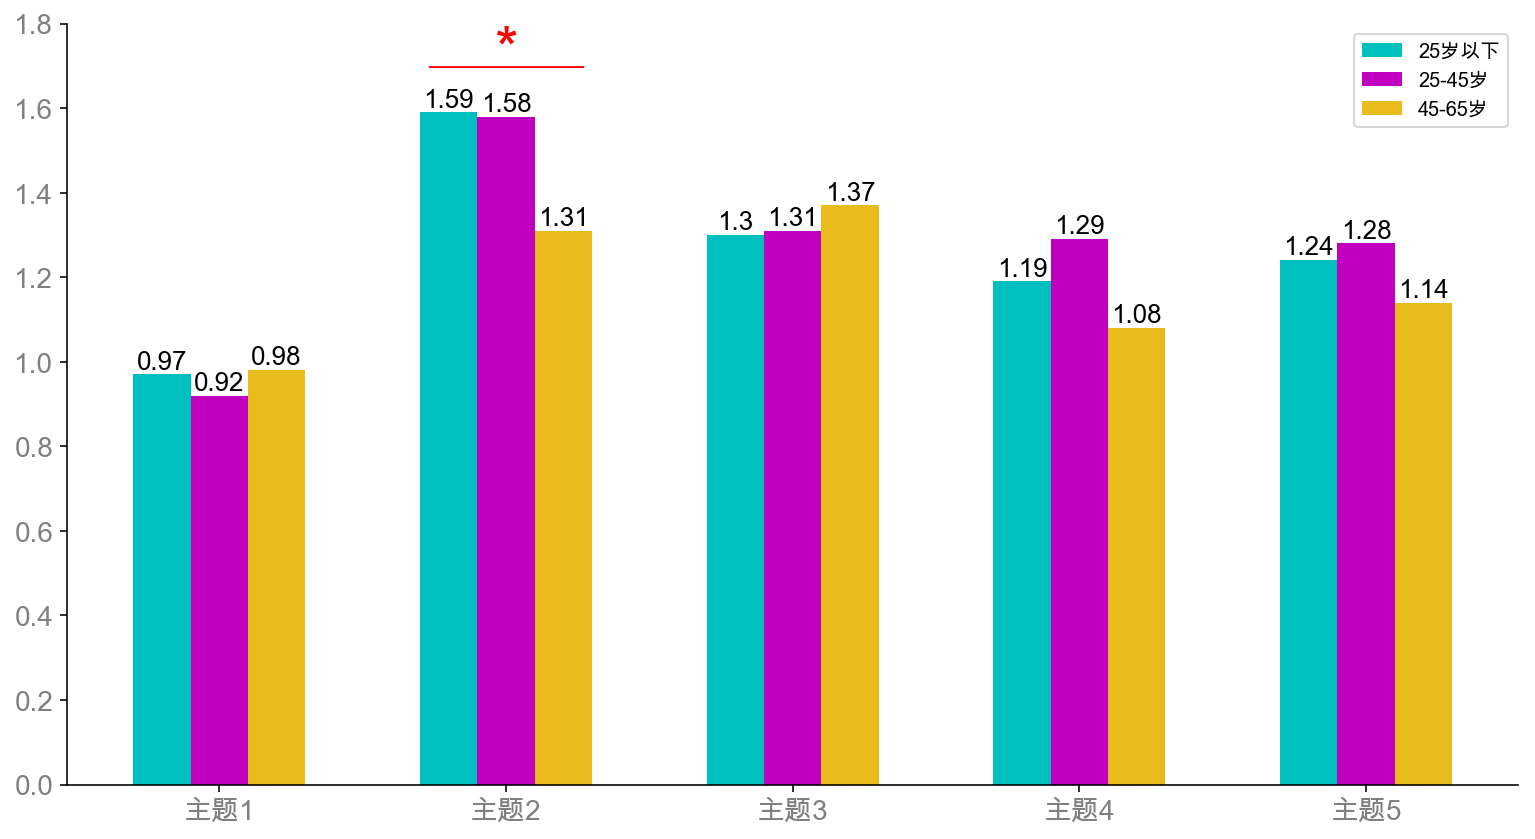

In [908]:
# plt.subplot(2,2,2)
# x = list(subject_age_dict.keys())
xticks = [i for i in range(1,6)]
subjects = [f'主题{i+1}' for i in range(5)]
fig, ax = plt.subplots(figsize=(13,7))
x = np.array([i+1 for i in range(5)])
plt.yticks(size=14, color='grey')
plt.xticks(xticks, subjects, size=14, color='grey')
plt.bar(x-0.2,
        height = age1_support,
        width = 0.2,
        align = "center",
        facecolor = "c",
        label = "25岁以下")
plt.bar(x,
        height = age2_support,
        width = 0.2,
        align = "center",
        facecolor = "m",
        label = "25-45岁")
plt.bar(x+0.2,
        height = age3_support,
        width = 0.2,
        align = "center",
        facecolor = "#e9bb1d",
        label = "45-65岁")
y_b = 0.03
for a,b in zip(x-0.2,age1_support):
    plt.text(a,b+y_b,b,va = "center",ha = "center",fontsize=13)
for a,b in zip(x,age2_support):
    plt.text(a,b+y_b,b,va = "center",ha = "center",fontsize=13)
for a,b in zip(x,age3_support):
    plt.text(a+0.2,b+y_b,b,va = "center",ha = "center",fontsize=13)

plt.text(2,1.7,'——————',va = "center",ha = "center",fontsize=13,color='red')
plt.text(2,1.73,'*',va = "center",ha = "center",fontsize=30,color='red')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim((0,1.8))
# plt.xticks()
plt.legend()
plt.savefig('./pic/compare1.png',dpi=600)
plt.show()


### 年龄-方差分析

In [665]:
# for subject,data_groupby_age in data_age_support.groupby('年龄'):
# #     subject = f'主题{subject[-1]}'
#     print(subject)
for i in range(1,6):
    subject = f'7-1-{i}'
    one_way_anova(data_age_support, '年龄', subject, alpha=0.05)

In [666]:
one_way_anova(data_age_support, '年龄', '7-1-1', alpha=0.05)

,差异源,平方和SS,自由度df,均方MS,F值,P值,F临界值,R^2
0,组间,0.379941,2,0.189971,0.180549,0.83486,3.01176,0.000642111
1,组内,591.326254,562,1.05218,_,_,_,_
2,总和,591.706195,564,_,_,_,_,_


In [667]:
one_way_anova(data_age_support, '年龄', '7-1-2', alpha=0.05)

,差异源,平方和SS,自由度df,均方MS,F值,P值,F临界值,R^2
0,组间,3.438452,2,1.71923,3.86939,0.0214295,3.01176,0.013583
1,组内,249.704911,562,0.444315,_,_,_,_
2,总和,253.143363,564,_,_,_,_,_


In [668]:
one_way_anova(data_age_support, '年龄', '7-1-3', alpha=0.05)

,差异源,平方和SS,自由度df,均方MS,F值,P值,F临界值,R^2
0,组间,0.224238,2,0.112119,0.174569,0.839864,3.01176,0.000620856
1,组内,360.950983,562,0.642262,_,_,_,_
2,总和,361.175221,564,_,_,_,_,_


In [669]:
one_way_anova(data_age_support, '年龄', '7-1-4', alpha=0.05)

,差异源,平方和SS,自由度df,均方MS,F值,P值,F临界值,R^2
0,组间,2.673016,2,1.33651,1.9253,0.146793,3.01176,0.00680497
1,组内,390.130524,562,0.694182,_,_,_,_
2,总和,392.803540,564,_,_,_,_,_


In [670]:
one_way_anova(data_age_support, '年龄', '7-1-5', alpha=0.05)

,差异源,平方和SS,自由度df,均方MS,F值,P值,F临界值,R^2
0,组间,0.989877,2,0.494938,0.682148,0.505948,3.01176,0.00242169
1,组内,407.764106,562,0.725559,_,_,_,_
2,总和,408.753982,564,_,_,_,_,_


### 二因素方差分析

In [1048]:
def f_twoway(df_c,col_fac1,col_fac2,col_sta,interaction=False):
    '''
    二因素方差分析函数
    '''
    pd.set_option('precision', 3)
    df=df_c.copy()
    list_fac1=df[col_fac1].unique()
    list_fac2=df[col_fac2].unique()
    r=len(list_fac1)
    s=len(list_fac2)
    x_bar=df[col_sta].mean()
    list_Qa=[]
    list_Qb=[]
    for i in list_fac1:
        series_i=df[df[col_fac1]==i][col_sta]
        xi_bar=series_i.mean()
        list_Qa.append((xi_bar-x_bar)**2)
    for j in list_fac2:
        series_j=df[df[col_fac2]==j][col_sta]
        xj_bar=series_j.mean()
        list_Qb.append((xj_bar-x_bar)**2)
    Q=((df[col_sta]-x_bar)**2).sum()
    df_res=pd.DataFrame(columns=['方差来源','平方和','自由度','均方','F值','Sig.'])
    if interaction==False:
        Qa=s*sum(list_Qa)
        Qb=r*sum(list_Qb)
        Qw=Q-Qa-Qb
        Sa=Qa/(r-1)
        Sb=Qb/(s-1)
        Sw=Qw/((r-1)*(s-1))
        sig1=stats.f.sf(Sa/Sw,r-1,(r-1)*(s-1))
        sig2=stats.f.sf(Sb/Sw,s-1,(r-1)*(s-1))
        df_res['方差来源']=[col_fac1,col_fac2,'误差','总和']
        df_res['平方和']=[Qa,Qb,Qw,Q]
        df_res['自由度']=[r-1,s-1,(r-1)*(s-1),r*s-1]
        df_res['均方']=[Sa,Sb,Sw,'-']
        df_res['F值']=[Sa/Sw,Sb/Sw,'-','-']
        df_res['Sig.']=[sig1,sig2,'-','-']
        return df_res
    elif interaction==True:
        list_Qw=[]
        t=len(df[(df[col_fac1]==list_fac1[0]) & (df[col_fac2]==list_fac2[0])])
        for i in list_fac1:
            for j in list_fac2:
                series_ij=df[(df[col_fac1]==i) & (df[col_fac2]==j)][col_sta]
                list_Qw.append(((series_ij-series_ij.mean())**2).sum())
        Qa=s*t*sum(list_Qa)
        Qb=r*t*sum(list_Qb)
        Qw=sum(list_Qw)
        Qab=Q-Qa-Qb-Qw
        Sa=Qa/(r-1)
        Sb=Qb/(s-1)
        Sab=Qab/((r-1)*(s-1))
        Sw=Qw/(r*s*(t-1))
        
        sig1=stats.f.sf(Sa/Sw,r-1,r*s*(t-1))
        sig2=stats.f.sf(Sb/Sw,s-1,r*s*(t-1))
        sig3=stats.f.sf(Sab/Sw,(r-1)*(s-1),r*s*(t-1))

        sig1 = float('%.3f' %sig1)
        sig2 = float('%.3f' %sig2)
        sig3 = float('%.3f' %sig3)

        
        df_res['方差来源']=[col_fac1,col_fac2,col_fac1+'*'+col_fac2,'误差','总和']
        df_res['平方和']=[Qa,Qb,Qab,Qw,Q]
        df_res['自由度']=[r-1,s-1,(r-1)*(s-1),r*s*(t-1),r*s*t-1]
        df_res['均方']=[Sa,Sb,Sab,Sw,'-']
        df_res['F值']=[Sa/Sw,Sb/Sw,Sab/Sw,'-','-']
        df_res['Sig.']=[sig1,sig2,sig3,'-','-']
#         df_res.set_option('precision', 3)
        return df_res
    else:
        return 'interaction参数错误'



In [876]:
data_age_subject_support.head()

,id,年龄,主题,支持度
0,1,1,主题1,1
1,2,1,主题2,1
2,3,1,主题3,1
3,4,1,主题4,1
4,5,1,主题5,1


In [1046]:
f_twoway(data_age_subject_support,'年龄','主题','支持度',interaction=True)

,方差来源,平方和,自由度,均方,F值,Sig.
0,年龄,5.197,2,2.6,2.61,0.074
1,主题,80.285,4,20.1,20.2,0
2,年龄*主题,34.226,8,4.28,4.3,0
3,误差,1999.877,2010,0.995,-,-
4,总和,2119.584,2024,-,-,-


## 性别-主题-支持度分析

In [885]:
count =0
hang = 0
data_gender_subject_support = pd.DataFrame(data=None,columns=['id','性别','主题','支持度'])
for i in range(data3.shape[0]):
    for i in range(1,6):
        count +=1
        data_gender_subject_support = data_gender_subject_support.append({
            'id':count,
            '性别':data3.at[hang,'性别'],
            '主题':f'主题{i}',
            '支持度':data3.at[hang,f'7-1-{i}'],
        },ignore_index=True)
    hang += 1

In [745]:
## 数据转换
data_gender_support = data3[['序号','性别','7-1-1','7-1-2','7-1-3','7-1-4','7-1-5']]

In [746]:
subject_gender_dict = {}
for i in range(5):
    subject = f'主题{i+1}'
    subject_gender_dict[subject] = {}

gender = 1
for subject,data_groupby_gender in data_gender_support.groupby('性别'):
    for i in range(5):
        n = i+1
        subject = f'主题{n}'
        series = data_groupby_gender[f'7-1-{n}']
        support = round(sum(series)/len(series),2)
        print(support)
        subject_gender_dict[subject][gender] = support
    gender += 1

0.9
1.56
1.3
1.25
1.34
0.96
1.56
1.32
1.25
1.2


In [747]:
subject_gender_dict

{'主题1': {1: 0.9, 2: 0.96},
 '主题2': {1: 1.56, 2: 1.56},
 '主题3': {1: 1.3, 2: 1.32},
 '主题4': {1: 1.25, 2: 1.25},
 '主题5': {1: 1.34, 2: 1.2}}

In [749]:
gender1_support = []
for v in subject_gender_dict.values():
    gender1_support.append(v[1])
gender2_support = []
for v in subject_gender_dict.values():
    gender2_support.append(v[2])

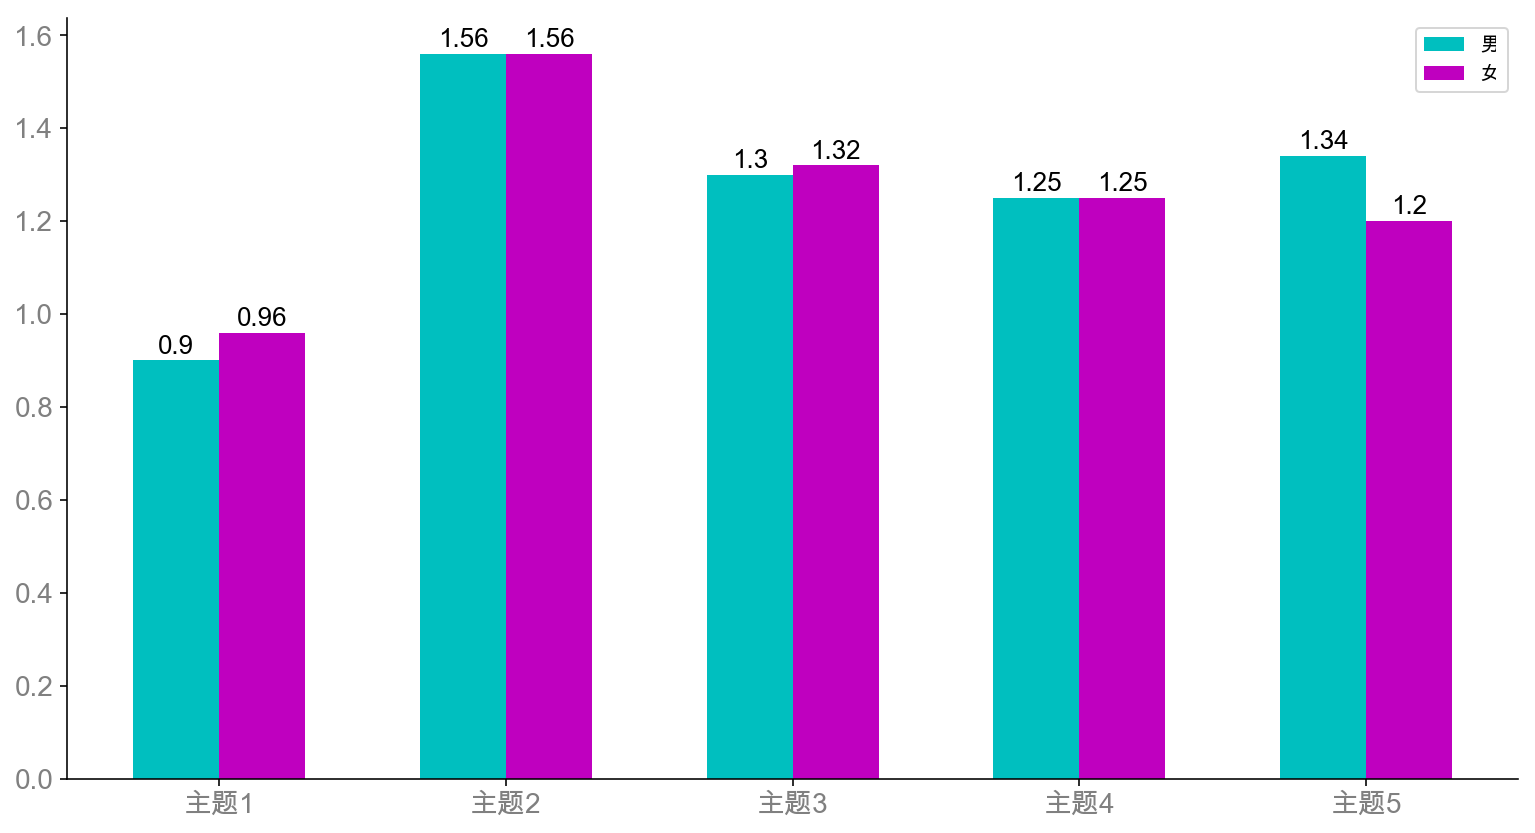

In [754]:
# plt.subplot(2,2,2)
# x = list(subject_age_dict.keys())
xticks = [i for i in range(1,6)]
subjects = [f'主题{i+1}' for i in range(5)]
fig, ax = plt.subplots(figsize=(13,7))
x = np.array([i+1 for i in range(5)])
plt.yticks(size=14, color='grey')
plt.xticks(xticks, subjects, size=14, color='grey')
plt.bar(x-0.15,
        height = gender1_support,
        width = 0.3,
        align = "center",
        facecolor = "c",
        label = "男")
plt.bar(x+0.15,
        height = gender2_support,
        width = 0.3,
        align = "center",
        facecolor = "m",
        label = "女")
y_b = 0.03
for a,b in zip(x-0.15,gender1_support):
    plt.text(a,b+y_b,b,va = "center",ha = "center",fontsize=13)
for a,b in zip(x+0.15,gender2_support):
    plt.text(a,b+y_b,b,va = "center",ha = "center",fontsize=13)
# for a,b in zip(x,age3_support):
#     plt.text(a+0.2,b+y_b,b,va = "center",ha = "center",fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.xticks()
plt.legend()
plt.savefig('./pic/compare2_gender.png',dpi=600)
plt.show()


### 二因素方差分析

In [886]:
f_twoway(data_gender_subject_support,'性别','主题','支持度',interaction=True)

,方差来源,平方和,自由度,均方,F值,Sig.
0,性别,0.117201,1,0.117201,0.150867,0.69774
1,主题,102.685133,4,25.6713,33.0454,6.50884e-27
2,性别*主题,12.512262,4,3.12807,4.02661,0.00293632
3,误差,2004.269829,2580,0.776849,-,-
4,总和,2119.584425,2589,-,-,-


### 性别-主题 显著性分析

In [834]:
data_age_support = data3[['序号','性别','7-1-1','7-1-2','7-1-3','7-1-4','7-1-5']]

In [835]:
one_way_anova(data_age_support, '性别', '7-1-1', alpha=0.05)

,差异源,平方和SS,自由度df,均方MS,F值,P值,F临界值,R^2
0,组间,0.514747,1,0.514747,0.490201,0.484127,3.85803,0.000869937
1,组内,591.191448,563,1.05007,_,_,_,_
2,总和,591.706195,564,_,_,_,_,_


In [836]:
one_way_anova(data_age_support, '性别', '7-1-2', alpha=0.05)

,差异源,平方和SS,自由度df,均方MS,F值,P值,F临界值,R^2
0,组间,0.003345,1,0.00334466,0.00743875,0.9313,3.85803,1.32125e-05
1,组内,253.140018,563,0.449627,_,_,_,_
2,总和,253.143363,564,_,_,_,_,_


In [837]:
one_way_anova(data_age_support, '性别', '7-1-3', alpha=0.05)

,差异源,平方和SS,自由度df,均方MS,F值,P值,F临界值,R^2
0,组间,0.051190,1,0.0511896,0.0798057,0.777665,3.85803,0.000141731
1,组内,361.124032,563,0.641428,_,_,_,_
2,总和,361.175221,564,_,_,_,_,_


In [838]:
one_way_anova(data_age_support, '性别', '7-1-4', alpha=0.05)

,差异源,平方和SS,自由度df,均方MS,F值,P值,F临界值,R^2
0,组间,0.000565,1,0.000564579,0.000809204,0.977316,3.85803,1.43731e-06
1,组内,392.802975,563,0.697696,_,_,_,_
2,总和,392.803540,564,_,_,_,_,_


In [839]:
one_way_anova(data_age_support, '性别', '7-1-5', alpha=0.05)

,差异源,平方和SS,自由度df,均方MS,F值,P值,F临界值,R^2
0,组间,2.742626,1,2.74263,3.80309,0.0516539,3.85803,0.00670972
1,组内,406.011356,563,0.721157,_,_,_,_
2,总和,408.753982,564,_,_,_,_,_


## 省份-主题-支持度分析

In [676]:
subject_province_support_dict = {}
for i in range(1,6):
    subject_province_support_dict[f'主题{i}']={}

In [677]:
for province,data_groupby_province in data3.groupby('省份'):
    print(province)
    for i in range(1,6):
        subject = f'7-1-{i}'
        support = sum(data_groupby_province[subject])
        subject_province_support_dict[f'主题{i}'][province] = support

上海
北京
四川
山东
广东
江苏
河南
浙江
湖北
辽宁
陕西


In [678]:
subject_province_support_dict

{'主题1': {'上海': 88,
  '北京': 60,
  '四川': 12,
  '山东': 96,
  '广东': 55,
  '江苏': 29,
  '河南': 21,
  '浙江': 73,
  '湖北': 24,
  '辽宁': 26,
  '陕西': 45},
 '主题2': {'上海': 139,
  '北京': 95,
  '四川': 22,
  '山东': 157,
  '广东': 90,
  '江苏': 52,
  '河南': 33,
  '浙江': 140,
  '湖北': 35,
  '辽宁': 62,
  '陕西': 57},
 '主题3': {'上海': 127,
  '北京': 79,
  '四川': 16,
  '山东': 143,
  '广东': 76,
  '江苏': 44,
  '河南': 19,
  '浙江': 105,
  '湖北': 29,
  '辽宁': 53,
  '陕西': 50},
 '主题4': {'上海': 107,
  '北京': 83,
  '四川': 18,
  '山东': 126,
  '广东': 79,
  '江苏': 37,
  '河南': 26,
  '浙江': 108,
  '湖北': 23,
  '辽宁': 58,
  '陕西': 39},
 '主题5': {'上海': 119,
  '北京': 71,
  '四川': 18,
  '山东': 115,
  '广东': 78,
  '江苏': 48,
  '河南': 25,
  '浙江': 109,
  '湖北': 31,
  '辽宁': 57,
  '陕西': 41}}

In [683]:
import itertools
list1 = [1, 2, 3, 4, 5]
#所有组合结果
print(list(itertools.combinations(list1, 2)))

[(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]


In [693]:
subject_province_support_dict

{'主题1': {'上海': 88,
  '北京': 60,
  '四川': 12,
  '山东': 96,
  '广东': 55,
  '江苏': 29,
  '河南': 21,
  '浙江': 73,
  '湖北': 24,
  '辽宁': 26,
  '陕西': 45},
 '主题2': {'上海': 139,
  '北京': 95,
  '四川': 22,
  '山东': 157,
  '广东': 90,
  '江苏': 52,
  '河南': 33,
  '浙江': 140,
  '湖北': 35,
  '辽宁': 62,
  '陕西': 57},
 '主题3': {'上海': 127,
  '北京': 79,
  '四川': 16,
  '山东': 143,
  '广东': 76,
  '江苏': 44,
  '河南': 19,
  '浙江': 105,
  '湖北': 29,
  '辽宁': 53,
  '陕西': 50},
 '主题4': {'上海': 107,
  '北京': 83,
  '四川': 18,
  '山东': 126,
  '广东': 79,
  '江苏': 37,
  '河南': 26,
  '浙江': 108,
  '湖北': 23,
  '辽宁': 58,
  '陕西': 39},
 '主题5': {'上海': 119,
  '北京': 71,
  '四川': 18,
  '山东': 115,
  '广东': 78,
  '江苏': 48,
  '河南': 25,
  '浙江': 109,
  '湖北': 31,
  '辽宁': 57,
  '陕西': 41}}

In [764]:
data_province_subject_support = pd.DataFrame(data=None,columns=['id','省份','主题','支持度'])

In [765]:
count  = 0
for subject in subject_province_support_dict.keys():
    dict1 = subject_province_support_dict[subject]
#     support_temp = []
    for province in dict1.keys():
        count += 1
        support = round(dict1[province]/province_population[province],2)
#         support_temp.append(support)
#         support_subject_sum = sum(support_temp)
        data_province_subject_support = data_province_subject_support.append( \
            {'id':count,'省份':province,'主题':subject,'支持度':support},ignore_index=True)
        

In [766]:
data_province_subject_support.sample(4)

,id,省份,主题,支持度
2,3,四川,主题1,0.86
30,31,湖北,主题3,1.12
29,30,浙江,主题3,1.17
49,50,江苏,主题5,1.71


### 气泡图

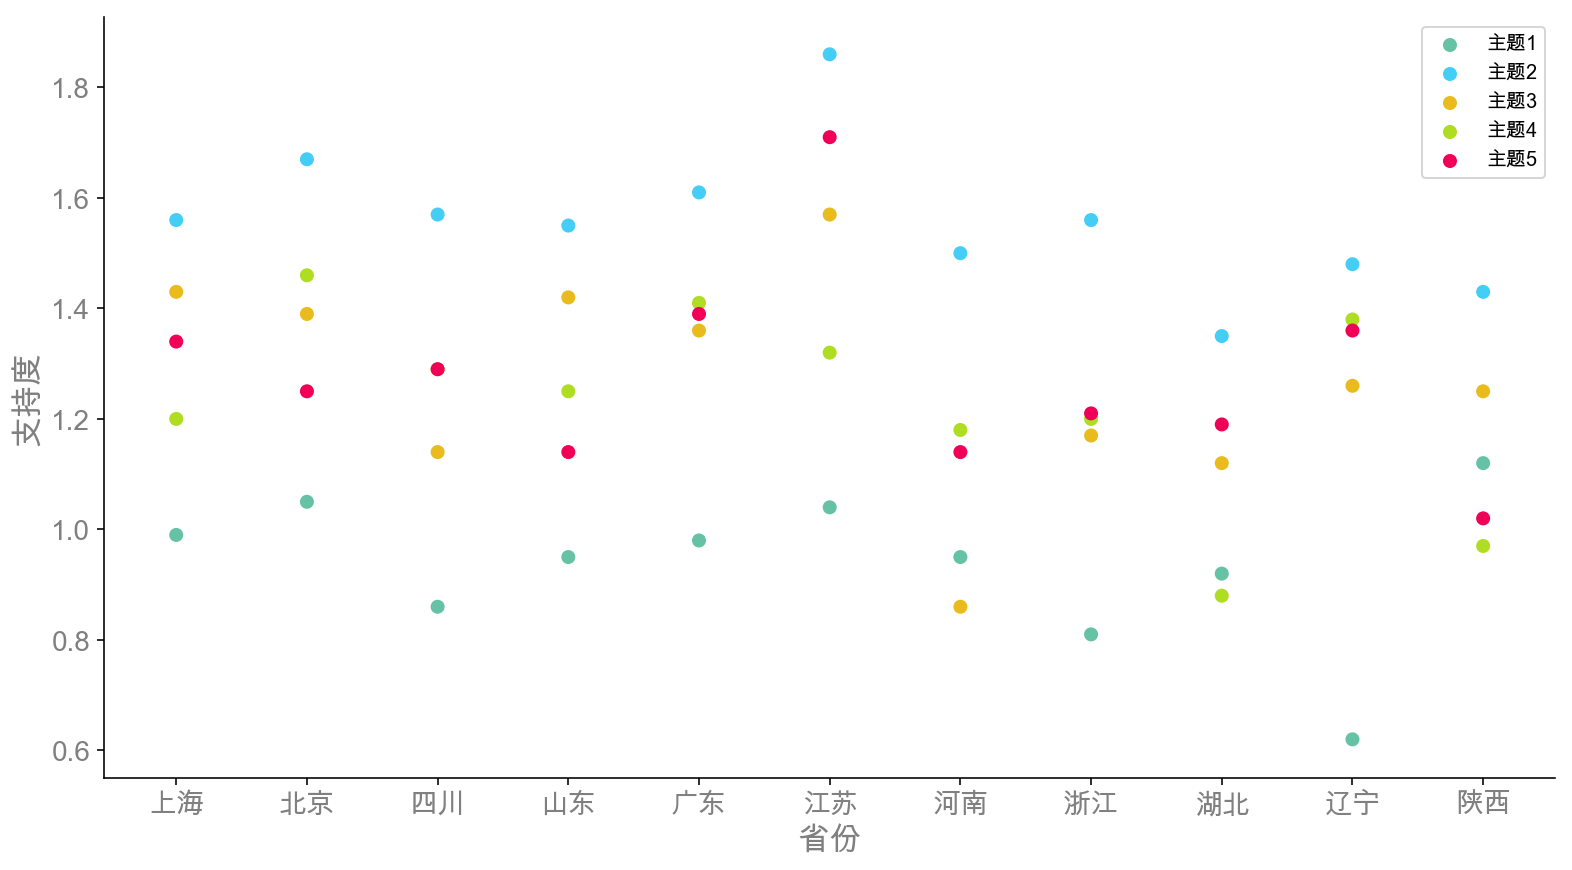

In [849]:
fig, ax = plt.subplots(figsize=(13,7))
colors = {1:'#66c2a5',2:'#44cef6',3:'#e9bb1d',4:'#afdd22',5:'#f00056'}

for subject,d in data_province_subject_support.groupby('主题'):
    plt.scatter(d['省份'],d['支持度'],color =[colors[int(i[-1])] for i in d['主题']],label = subject)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.xlabel(fontsize=20)
plt.yticks(size=14, color='grey')
plt.xticks(size=14, color='grey')
plt.ylabel('支持度',fontsize=16,color='grey')
plt.xlabel('省份',fontsize=16,color='grey')
plt.legend()
plt.savefig('./pic/province_subject_support.png',dpi=500)
plt.show()

In [845]:
# 原始数据
data_province_subject_support.to_csv('./to_csv/省份_主题_支持度.csv')

In [1059]:
## 堆积柱状图
subject_province_support_rate_dict = {}

In [1061]:
a = {1:1,2:2}
a.items()

dict_items([(1, 1), (2, 2)])

In [1064]:
for subject in subject_province_support_dict.keys():
    subject_province_support_rate_dict[subject] = {}
    sum1 = sum(subject_province_support_dict[subject].values())
    for k_v in subject_province_support_dict[subject].items():
        rate = round(k_v[1]/sum1,3)
        subject_province_support_rate_dict[subject][k_v[0]] = rate


In [1067]:
# subject_province_support_rate_dict
province_subject_support_rate_dict = {}
for province in subject_province_support_rate_dict['主题1'].keys():
    province_subject_support_rate_dict[province] = []
for subject,dict2 in subject_province_support_rate_dict.items():
    for province in dict2.keys():
        province_subject_support_rate_dict[province].append(dict2[province])

In [1072]:
province_lists = [list(dd) for dd in province_subject_support_rate_dict.values()]

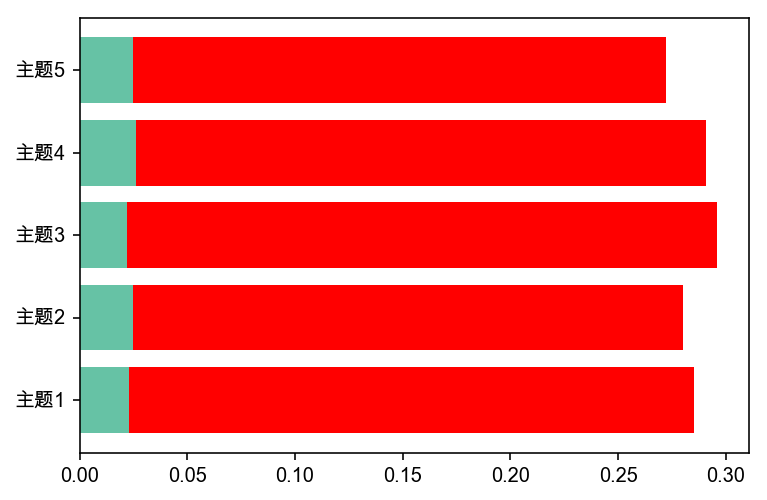

In [1080]:
## 堆积柱状图
for k,ls in enumerate(province_lists):
    if k==0:
        plt.barh(subjects, ls, align="center", color="#66c2a5", tick_label=subjects, label=f"班级{k+1}")
    else:
        ls_last = province_lists[k-1]
        plt.barh(subjects, ls, align="center", color="red", left=ls_last,tick_label=subjects, label=f"班级{k+1}")


### 省份-方差分析

In [1104]:
data_province_support_ls = [data_province_support1,data_province_support2,data_province_support3,data_province_support4,data_province_support5]
for kk,ddd in enumerate(data_province_support_ls):
    ddd.columns = ['省份','支持度']
    ddd['主题'] = f'主题{kk+1}'

data_province_support = data_province_support1.append(data_province_support2)
data_province_support = data_province_support.append(data_province_support3)
data_province_support = data_province_support.append(data_province_support4)
data_province_support = data_province_support.append(data_province_support5)
# data_province_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2825 entries, 0 to 564
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   省份      2825 non-null   object
 1   支持度     2825 non-null   int64 
 2   主题      2825 non-null   object
dtypes: int64(1), object(2)
memory usage: 88.3+ KB


In [1120]:
writer2 = pd.ExcelWriter('./to_csv/省X主题_单因素方差分析结果.xlsx')
for i in range(1,6):
    zhuti = f'7-1-{i}'
    subject = i+1
    data_province_support = data3[['省份',zhuti]]
    result = one_way_anova(data_province_support,'省份',zhuti)
    result.to_excel(writer2,f'主题{subject}')
writer2.save()

In [1106]:
## 双因素
f_twoway(data_province_support,'省份','主题','支持度',interaction=True)

,方差来源,平方和,自由度,均方,F值,Sig.
0,省份,29.785,10,2.98,3.43,0
1,主题,91.584,4,22.9,26.4,0
2,省份*主题,41.183,40,1.03,1.19,0.198
3,误差,1957.033,2255,0.868,-,-
4,总和,2119.584,2309,-,-,-


# 职业合并-data6

In [ ]:
'''
1-研究人员
教师、技术研发人员-215；
[12,10]
2-学生
学生-119；
[1]
3-文职
管理人员、专业人士、文职、人力资源、财务、客服人员-122；
[11,14,9,7,8,5]
4-商务人士
销售人员、行政后勤、市场、顾问-72；
[3,6,4,13]
5-其它
其它、生产人员-59
[15,2]

1:'全日制学生',
2:'生产人员',
3:'销售人员',
4:'市场/公关人员',
5:'客服人员',
6:'行政/后勤人员',
7:'人力资源',
8:'财务/审计人员',
9:'文职/办事人员',
10:'技术/研发人员',
11:'管理人员',
12:'教师',
13:'顾问/咨询',
14:'专业人士(如会计师、律师等)',
15:'其他'
'''

In [807]:
replace_list = [
    [12,10],
    [1],
    [11,14,9,7,8,5],
    [3,6,4,13],
    [15,2]
]

In [808]:
data6 = data3
for n,ls in enumerate(replace_list):
    new = str(n+1) 
    for old in ls:
        data6['职业'] = data6['职业'].replace(old,new)

In [809]:
data6['职业'].value_counts()

1    215
2    119
3    100
4     72
5     59
Name: 职业, dtype: int64

In [1133]:
data6.to_excel('./rawdata/data1.xlsx')

## 职业-主题-支持度分析

In [893]:
subject_job_support_dict = {}
for i in range(1,6):
    subject_job_support_dict[f'主题{i}']={}

In [894]:
for job,data_groupby_job in data6.groupby('职业'):
    print(job)
    for i in range(1,6):
        subject = f'7-1-{i}'
        support = sum(data_groupby_job[subject])
        subject_job_support_dict[f'主题{i}'][job] = support
    

1
2
3
4
5


In [895]:
data_job_subject_support = pd.DataFrame(data=None,columns=['id','职业','主题','支持度'])

In [896]:
job_population = {}
for job,data_groupby_job in data6.groupby('职业'):
    job_population[job] = len(data_groupby_job)

In [897]:
count  = 0
for subject in subject_job_support_dict.keys():
    dict1 = subject_job_support_dict[subject]
#     support_temp = []
    for job in dict1.keys():
        count += 1
        support = round(dict1[job]/job_population[job],2)
#         support_temp.append(support)
#         support_subject_sum = sum(support_temp)
        data_job_subject_support = data_job_subject_support.append( \
            {'id':count,'职业':job,'主题':subject,'支持度':support},ignore_index=True)
        

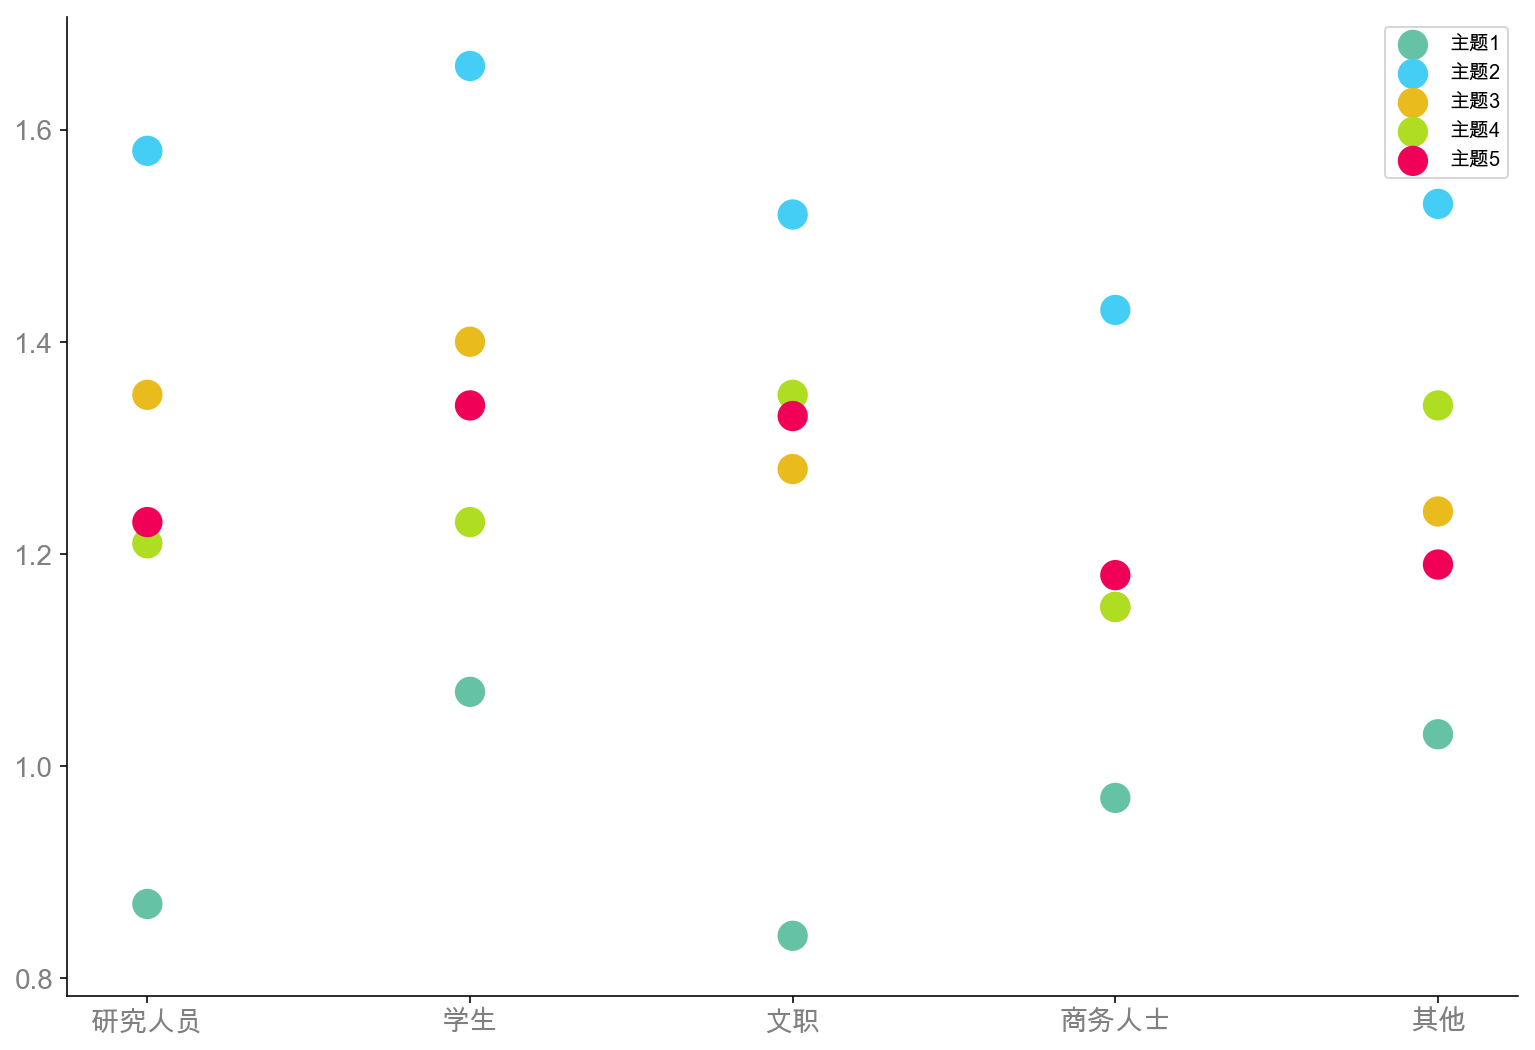

In [906]:
fig, ax = plt.subplots(figsize=(13,9))
colors = {1:'#66c2a5',2:'#44cef6',3:'#e9bb1d',4:'#afdd22',5:'#f00056'}
x_ticks_label = ['研究人员','学生','文职','商务人士','其他']
for subject,d in data_job_subject_support.groupby('主题'):
    plt.scatter(d['职业'],d['支持度'],color =[colors[int(i[-1])] for i in d['主题']],label = subject,s=200)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.xlabel(fontsize=20)
plt.yticks(size=14, color='grey')
plt.xticks(range(0,5),x_ticks_label,size=14, color='grey')
plt.legend()
plt.savefig('./pic/province_job_support.png',dpi=500)
plt.show()

### 方差分析


In [1117]:
data_job_support_ls = []
for i in range(1,6):
    d_ = data3[['职业',f'7-1-{i}']]
    data_job_support_ls.append(d_)

In [1118]:
# data_job_support_ls = [data_job_support1,data_province_support2,data_province_support3,data_province_support4,data_province_support5]
for kk,ddd in enumerate(data_job_support_ls):
    ddd.columns = ['职业','支持度']
    ddd['主题'] = f'主题{kk+1}'

data_job_support = data_job_support_ls[0].append(data_job_support_ls[1])
data_job_support = data_job_support.append(data_job_support_ls[2])
data_job_support = data_job_support.append(data_job_support_ls[3])
data_job_support = data_job_support.append(data_job_support_ls[4])
# data_province_support.info()

In [1121]:
writer2 = pd.ExcelWriter('./to_csv/职业X主题_单因素方差分析结果.xlsx')
for i in range(1,6):
    zhuti = f'7-1-{i}'
    subject = i+1
    data_province_support = data3[['职业',zhuti]]
    result = one_way_anova(data_province_support,'职业',zhuti)
    result.to_excel(writer2,f'主题{subject}')
writer2.save()

In [1119]:
## 双因素
f_twoway(data_job_support,'职业','主题','支持度',interaction=True)

,方差来源,平方和,自由度,均方,F值,Sig.
0,职业,4.903,4,1.23,1.09,0.359
1,主题,71.364,4,17.8,15.9,0
2,职业*主题,51.448,16,3.22,2.87,0
3,误差,1991.869,1775,1.12,-,-
4,总和,2119.584,1799,-,-,-


# 场景分析

In [913]:
subject_scene_sum = [
    7,9,5,6,16
]
question_numbers = [
    8,9,10,11,12
]

## 主题一场景 8-7

In [963]:
scene_sum = subject_scene_sum[0]
question_number = question_numbers[0]

In [964]:
count =0
hang = 0
data_age_subject1_scene_support = pd.DataFrame(data=None,columns=['id','年龄','性别','职业','场景','支持度'])
for i in range(data6.shape[0]):
    for i in range(1,scene_sum+1):
        count +=1
        data_age_subject1_scene_support = data_age_subject1_scene_support.append({
            'id':count,
            '年龄':data6.at[hang,'年龄'],
            '性别':data6.at[hang,'性别'],
            '职业':data6.at[hang,'职业'],
            '场景':f'场景{i}',
            '支持度':data6.at[hang,f'{question_number}-1-{i}'],
        },ignore_index=True)
    hang += 1

##  主题二场景 9-9

In [965]:
scene_sum = subject_scene_sum[1]
question_number = question_numbers[1]

In [966]:
count =0
hang = 0
data_age_subject2_scene_support = pd.DataFrame(data=None,columns=['id','年龄','性别','职业','场景','支持度'])
for i in range(data6.shape[0]):
    for i in range(1,scene_sum+1):
        count +=1
        data_age_subject2_scene_support = data_age_subject2_scene_support.append({
            'id':count,
            '年龄':data6.at[hang,'年龄'],
            '性别':data6.at[hang,'性别'],
            '职业':data6.at[hang,'职业'],
            '场景':f'场景{i}',
            '支持度':data6.at[hang,f'{question_number}-1-{i}'],
        },ignore_index=True)
    hang += 1

## 主题三场景 10-5

In [967]:
scene_sum = subject_scene_sum[2]
question_number = question_numbers[2]

In [968]:
count =0
hang = 0
data_age_subject3_scene_support = pd.DataFrame(data=None,columns=['id','年龄','性别','职业','场景','支持度'])
for i in range(data6.shape[0]):
    for i in range(1,scene_sum+1):
        count +=1
        data_age_subject3_scene_support = data_age_subject3_scene_support.append({
            'id':count,
            '年龄':data6.at[hang,'年龄'],
            '性别':data6.at[hang,'性别'],
            '职业':data6.at[hang,'职业'],
            '场景':f'场景{i}',
            '支持度':data6.at[hang,f'{question_number}-1-{i}'],
        },ignore_index=True)
    hang += 1

## 主题四场景 11-6

In [969]:
scene_sum = subject_scene_sum[3]
question_number = question_numbers[3]

In [970]:
count =0
hang = 0
data_age_subject4_scene_support = pd.DataFrame(data=None,columns=['id','年龄','性别','职业','场景','支持度'])
for i in range(data6.shape[0]):
    for i in range(1,scene_sum+1):
        count +=1
        data_age_subject4_scene_support = data_age_subject4_scene_support.append({
            'id':count,
            '年龄':data6.at[hang,'年龄'],
            '性别':data6.at[hang,'性别'],
            '职业':data6.at[hang,'职业'],
            '场景':f'场景{i}',
            '支持度':data6.at[hang,f'{question_number}-1-{i}'],
        },ignore_index=True)
    hang += 1

## 主题五场景 12-16

In [971]:
scene_sum = subject_scene_sum[4]
question_number = question_numbers[4]

In [972]:
count =0
hang = 0
data_age_subject5_scene_support = pd.DataFrame(data=None,columns=['id','年龄','性别','职业','场景','支持度'])
for i in range(data6.shape[0]):
    for i in range(1,scene_sum+1):
        count +=1
        data_age_subject5_scene_support = data_age_subject5_scene_support.append({
            'id':count,
            '年龄':data6.at[hang,'年龄'],
            '性别':data6.at[hang,'性别'],
            '职业':data6.at[hang,'职业'],
            '场景':f'场景{i}',
            '支持度':data6.at[hang,f'{question_number}-1-{i}'],
        },ignore_index=True)
    hang += 1

## 综合数据导出

In [981]:
data_5subject_scenes = [
    data_age_subject1_scene_support,
    data_age_subject2_scene_support,
    data_age_subject3_scene_support,
    data_age_subject4_scene_support,
    data_age_subject5_scene_support,
]
output_data_dict = {
    '主题1':{},
    '主题2':{},
    '主题3':{},
    '主题4':{},
    '主题5':{},
}
attrs= ['年龄','性别','职业']
for s_n,data_subject_scene in enumerate(data_5subject_scenes):
#     if s_n==4:
        subject = f'主题{s_n+1}'
        writer = pd.ExcelWriter(f'./to_csv/{subject}_年龄+性别+职业_支持度.xlsx')
        for attr in attrs:
            data_temp = pd.DataFrame(None,columns=['场景',attr,'支持度'])
            for attr_value,data_groupby_attr in data_subject_scene.groupby(attr):                
                for scene,data_groupby_scene in data_groupby_attr.groupby('场景'):
#                     print(scene,data_groupby_scene)
                    length = len(data_groupby_scene)
                    support = round(data_groupby_scene['支持度'].sum()/length,3)
                    data_temp = data_temp.append(
                    {
                        '场景':scene,
                        attr:attr_value,
                        '支持度':support
                    },ignore_index=True)
            output_data_dict[f'主题{s_n+1}'][attr] = data_temp
            data_temp.to_excel(writer,attr)
        writer.save()

## 综合绘图

### 性别

主题1
[1 2 3 4 5 6 7]


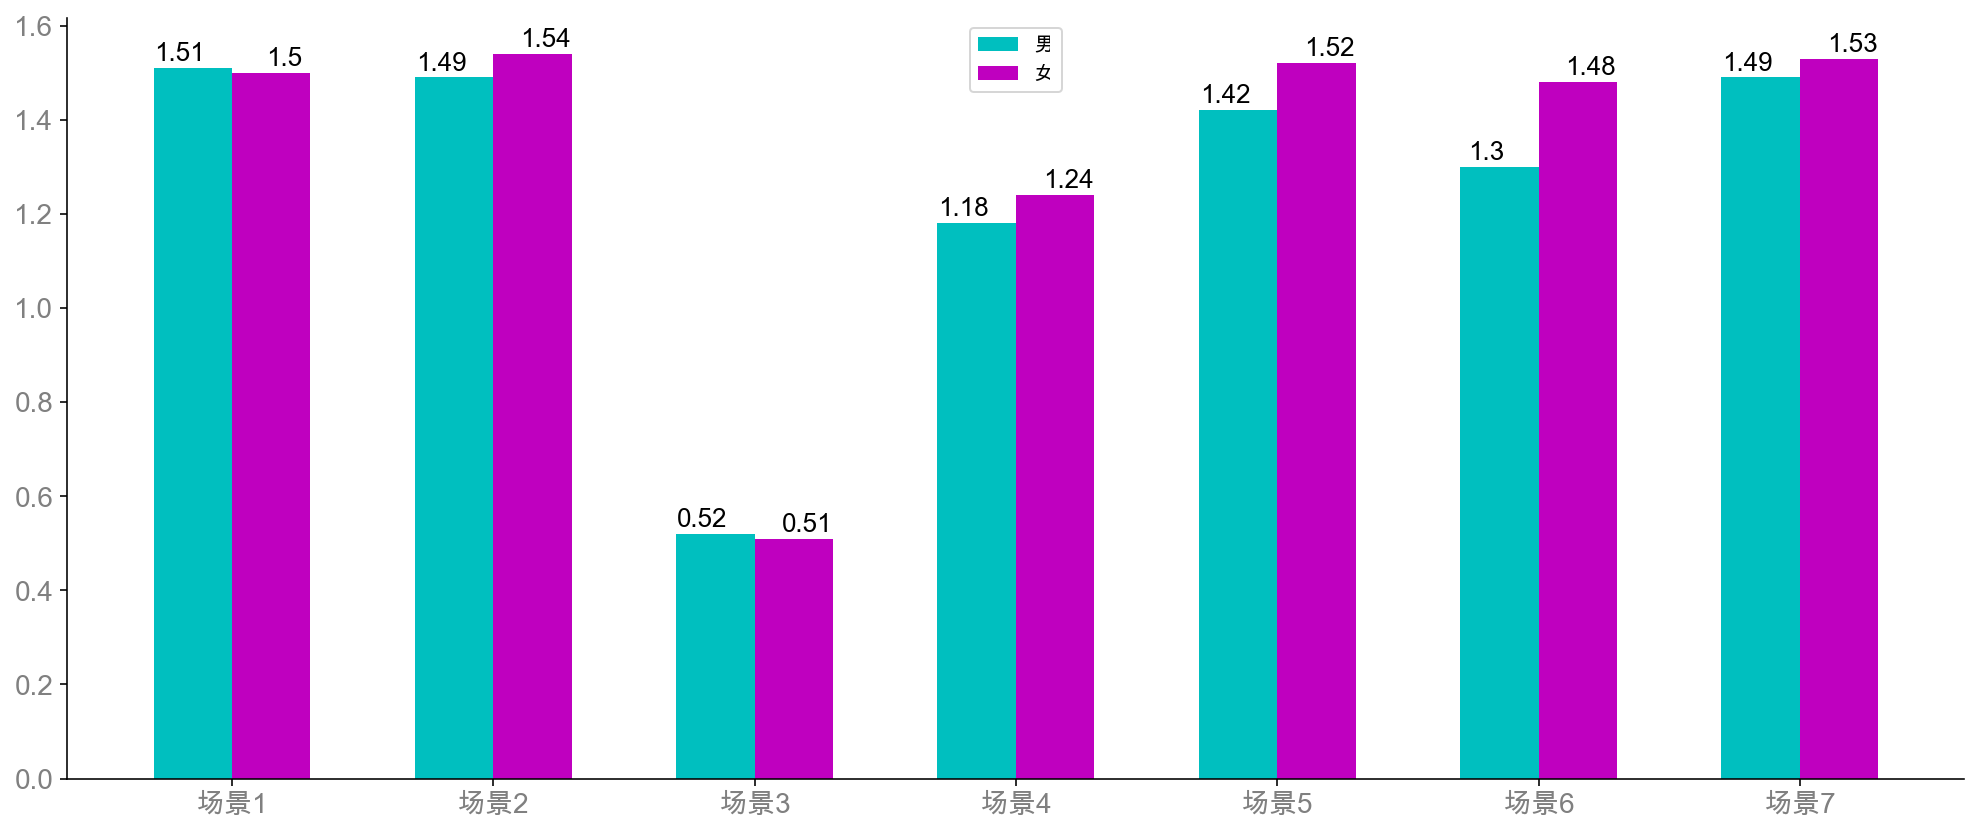

主题2
[1 2 3 4 5 6 7 8 9]


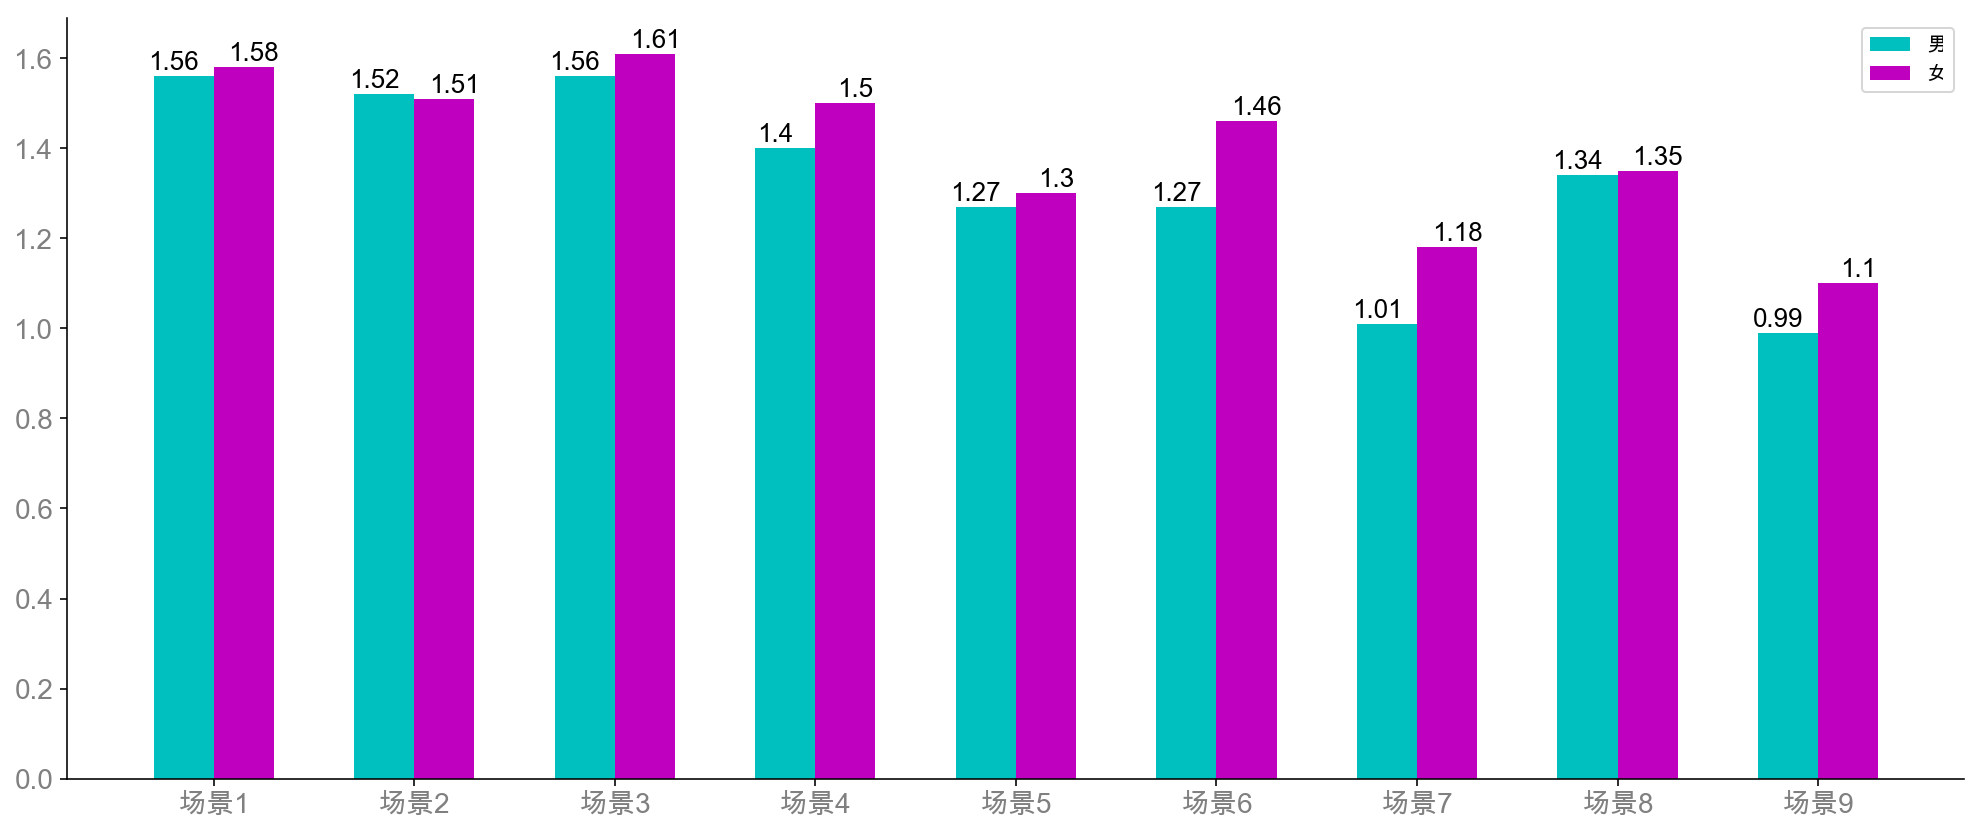

主题3
[1 2 3 4 5]


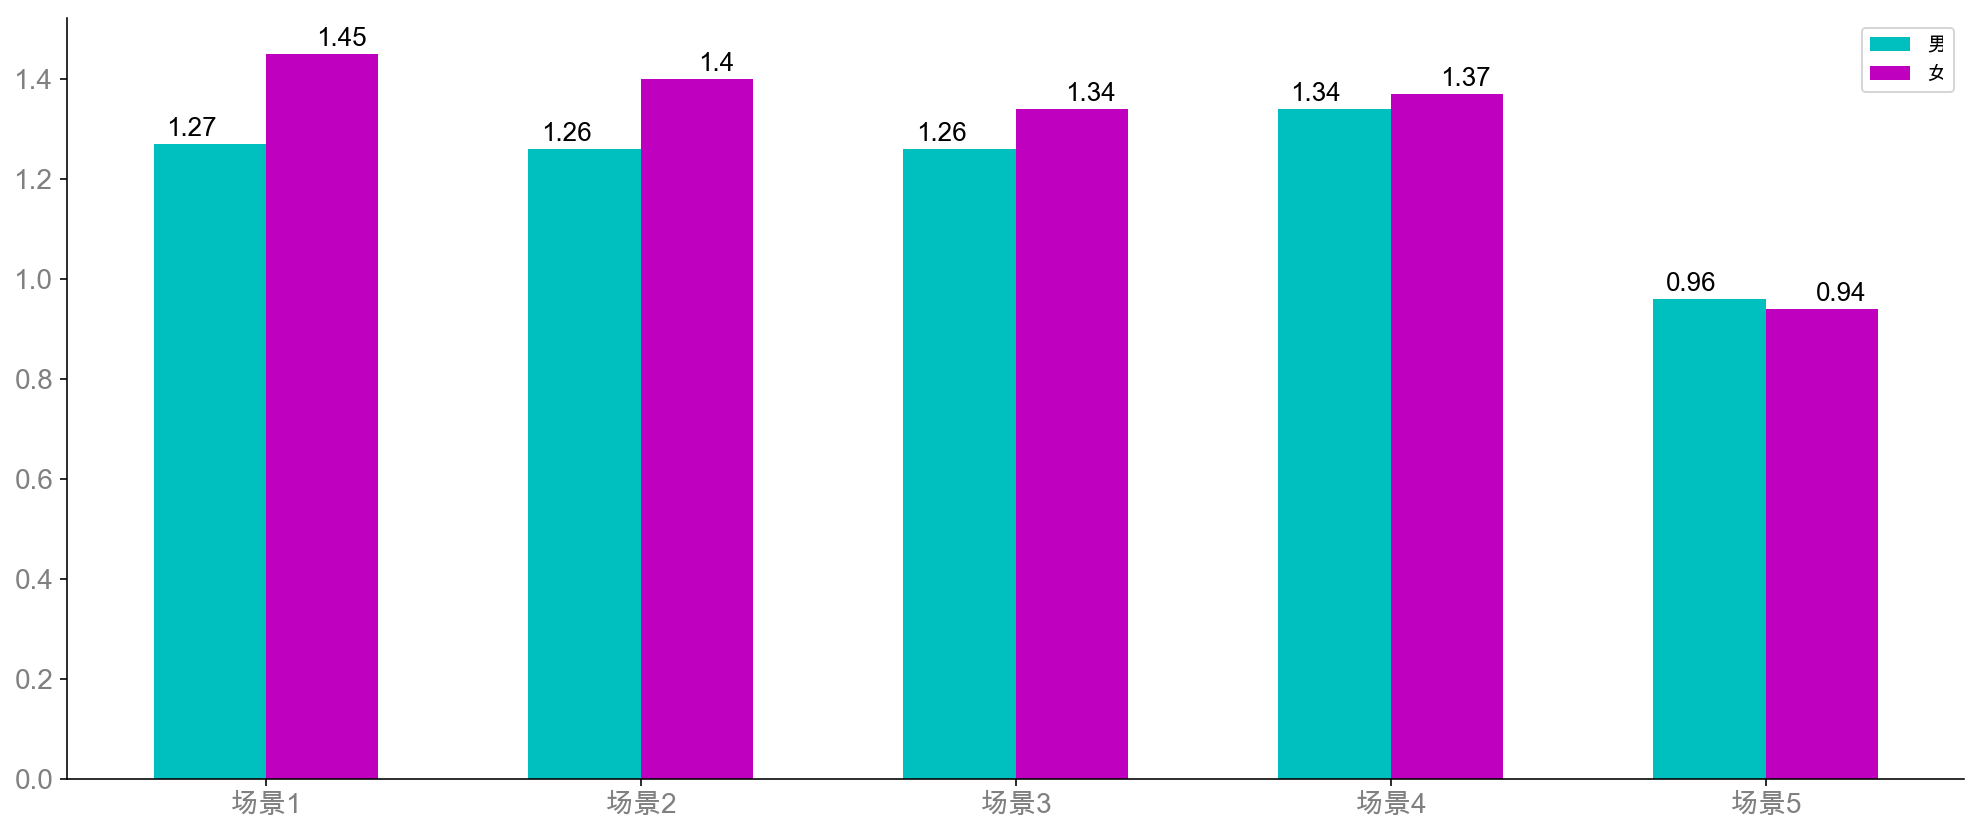

主题4
[1 2 3 4 5 6]


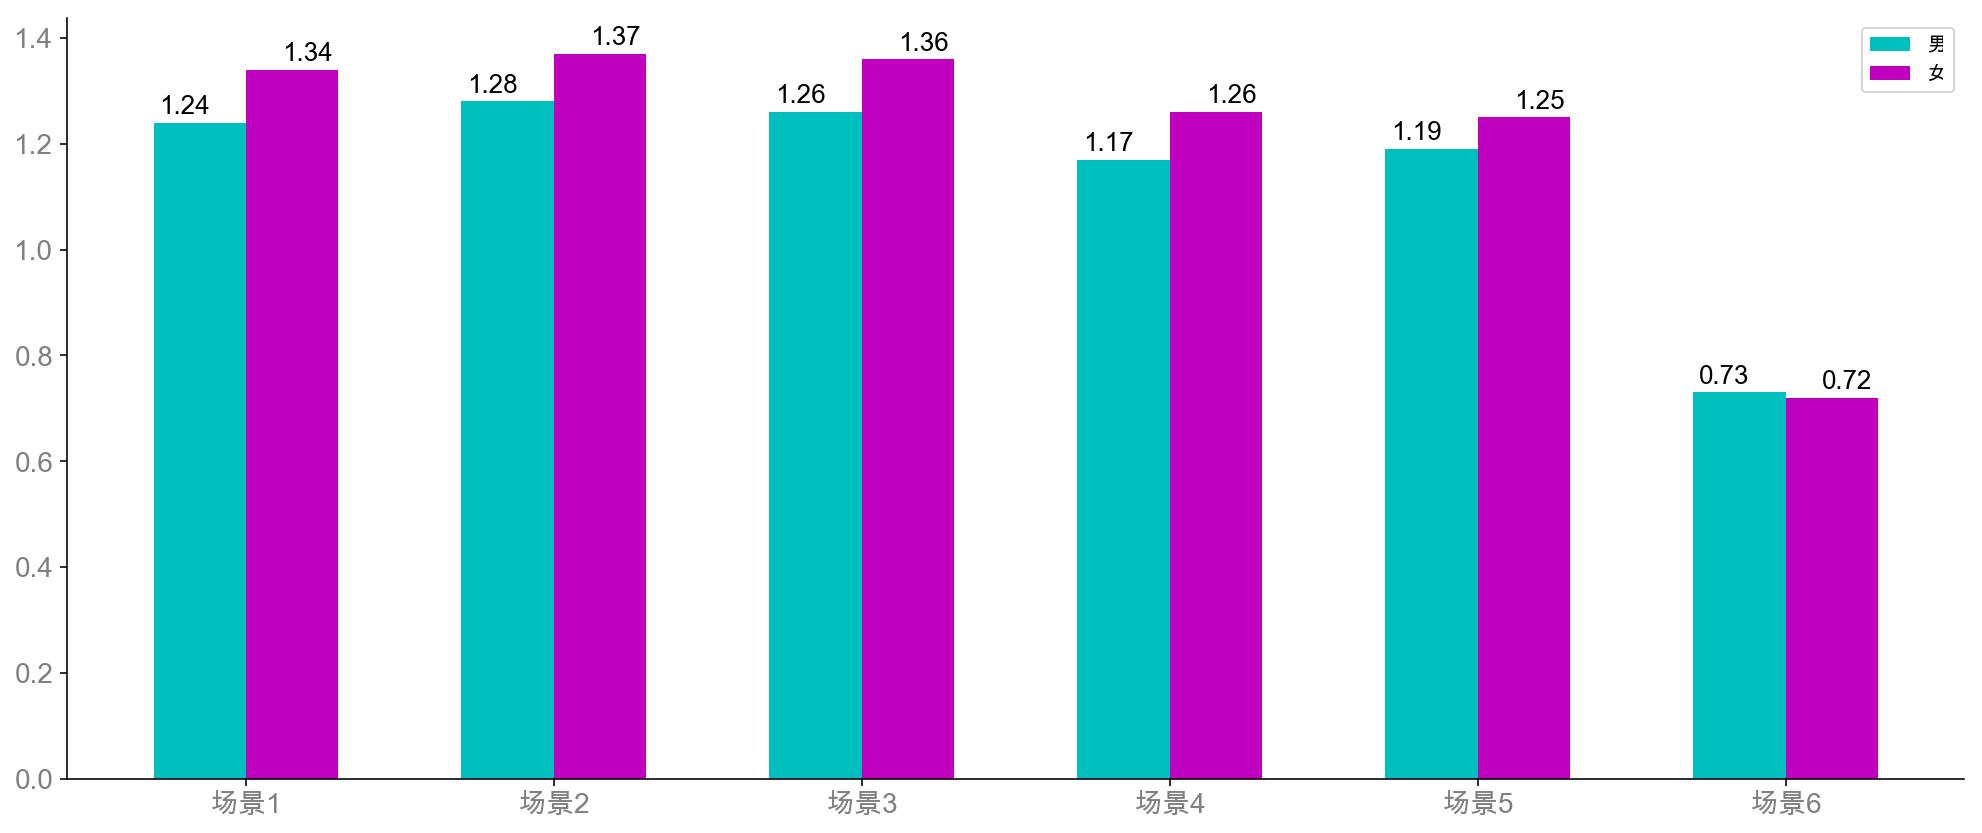

主题5
[ 1 10 11 12 13 14 15 16  2  3  4  5  6  7  8  9]


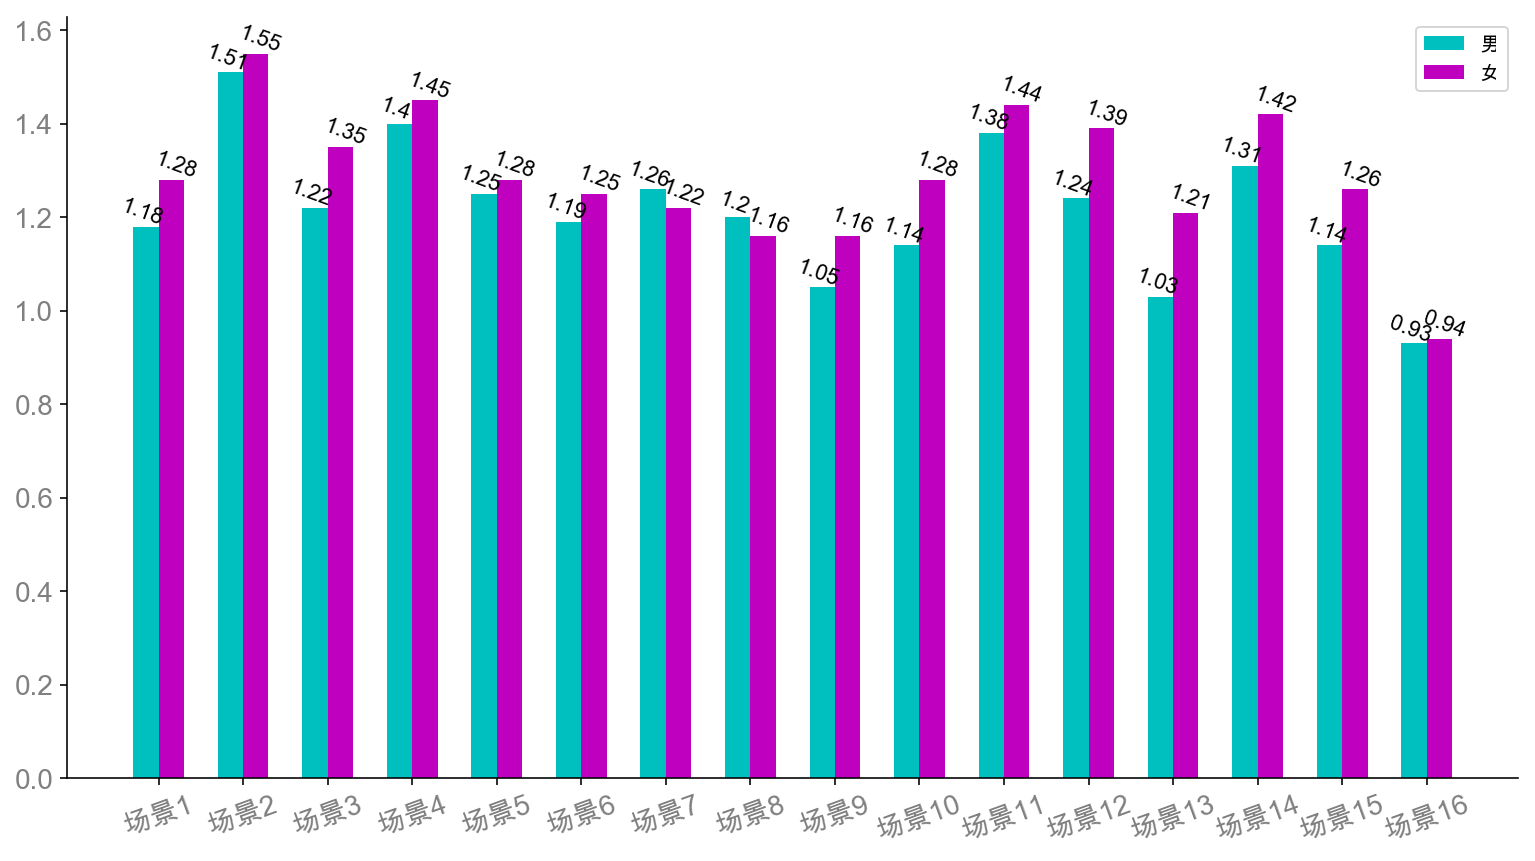

In [1023]:
for subject in output_data_dict.keys():  
#     if subject!='主题5':
#         continue
    print(subject)
    raw_data = output_data_dict[subject]['性别']
    xticks_number = len(raw_data['场景'].value_counts())
    scenes = []
    xticks = [i for i in range(1,xticks_number+1)]
#     scene = [f'场景{i+1}' for i in range(xticks_number)]
    if subject!='主题5':
        fig, ax = plt.subplots(figsize=(17,7))
    else:
        fig, ax = plt.subplots(figsize=(13,7))
    x = np.array([i+1 for i in range(xticks_number)])
    gender1_support,gender2_support = [],[]
    for gender,d_temp1 in raw_data.groupby('性别'):
        for scene,d_temp2 in d_temp1.groupby('场景'):
            if gender == 1:
                gender1_support.append(round(d_temp2.iloc[0,2],2))
                scenes.append(scene)
            else:
                gender2_support.append(round(d_temp2.iloc[0,2],2))
    a = np.array([int(scene.replace('场景','')) for scene in scenes])
    print(a)
    index = np.argsort(a)
    scenes = np.array(scenes)
    scenes = scenes[index]
    gender1_support,gender2_support = np.array(gender1_support),np.array(gender2_support)
    gender1_support = gender1_support[index]
    gender2_support = gender2_support[index]
    
    plt.yticks(size=14, color='grey') 
    if subject=='主题5':
        plt.xticks(xticks, scenes, size=14, color='grey',rotation=20)
    else:
        plt.xticks(xticks, scenes, size=14, color='grey')
    plt.bar(x-0.15,
            height = gender1_support,
            width = 0.3,
            align = "center",
            facecolor = "c",
            label = "男")
    plt.bar(x+0.15,
            height = gender2_support,
            width = 0.3,
            align = "center",
            facecolor = "m",
            label = "女")
    y_b = 0.03
    if subject =='主题5':
        for a,b in zip(x-0.2,gender1_support):
            plt.text(a,b+y_b,b,va = "center",ha = "center",fontsize=11,rotation=-20)
        for a,b in zip(x+0.2,gender2_support):
            plt.text(a,b+y_b,b,va = "center",ha = "center",fontsize=11,rotation=-20)
    else:
        for a,b in zip(x-0.2,gender1_support):
            plt.text(a,b+y_b,b,va = "center",ha = "center",fontsize=13)
        for a,b in zip(x+0.2,gender2_support):
            plt.text(a,b+y_b,b,va = "center",ha = "center",fontsize=13)
    # for a,b in zip(x,age3_support):
    #     plt.text(a+0.2,b+y_b,b,va = "center",ha = "center",fontsize=13)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.xticks()
    plt.legend()
    plt.savefig(f'./pic/{subject}compare_scene_gender.png',dpi=600)
    plt.show()

### 二因素方差分析

In [1049]:
writer2 = pd.ExcelWriter('./to_csv/二因素方差分析结果.xlsx')
for k,raw_data in enumerate(data_5subject_scenes):
    subject = k+1
    for attr in attrs:
        result = f_twoway(raw_data,attr,'场景','支持度',interaction=True)
        result.to_excel(writer2,f'主题{subject}_场景X'+attr)
writer2.save()
        